In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel, BertModel
from sklearn.model_selection import train_test_split
import json
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import ast
import spacy

nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # Default to CUDA
else:
    torch.set_default_tensor_type(torch.FloatTensor)  # Default to CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())
print(device)

True
cuda


Uncomment to get the dataset

In [4]:
!git clone https://github.com/EducationalTestingService/sarcasm.git
!mkdir -p /content/drive/MyDrive/FALL2024/comp550/final_project
!cp -r sarcasm /content/drive/MyDrive/FALL2024/comp550/final_project

Cloning into 'sarcasm'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 20), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 2.89 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (20/20), done.


# Utility Functions

In [5]:
def disconnect_runtime():
    """
    Disconnects the Google Colab runtime programmatically.
    """
    from google.colab import runtime
    print("Disconnecting the runtime...")
    runtime.unassign()



def load_jsonl_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data


def list_shape(lst):
    """
    Recursively determines the shape of a nested list.

    Args:
        lst (list): The input nested list.

    Returns:
        tuple: A tuple representing the shape of the list.
    """
    if isinstance(lst, list):
        if len(lst) == 0:
            return (0,)  # Empty list
        return (len(lst), *list_shape(lst[0]))
    else:
        return ()  # End of recursion for non-list elements


def custom_collate_fn(batch):
    contexts = [sample['context'] for sample in batch]
    responses = [sample['response'] for sample in batch]
    syntactic_features = torch.stack([sample['syntactic_features'] for sample in batch])
    labels = torch.stack([sample['label'] for sample in batch])

    # Process contexts and responses as needed
    # For example, flattening or stacking them appropriately
    return {
        'context': contexts,
        'response': responses,
        'syntactic_features': syntactic_features,
        'label': labels
    }



# Data Visualization

## Path Constants

## JSON files format (only use once to convert it to dataframe)

In [6]:
REDDIT_TRAINING_DATA_PATH_JSON = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/sarcasm_detection_shared_task_reddit_training.jsonl"
REDDIT_TESTING_DATA_PATH_JSON = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/sarcasm_detection_shared_task_reddit_testing.jsonl"
TWITTER_TRAINING_DATA_PATH_JSON = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
TWITTER_TESTING_DATA_PATH_JSON= "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl"

## Data frame format

In [7]:
REDDIT_TRAINING_PATH_DATAFRAME = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/train_val_split/training_set.csv"
REDDIT_VALIDATION_PATH_DATAFRAME = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/train_val_split/validation_set.csv"
REDDIT_TESTING_PATH_DATAFRAME = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/sarcasm_detection_reddit_testing.csv"

# Data Processing


In [8]:
def is_pad_tensor(tensor):
    correct_start = tensor[0][0] == 101
    correct_middle = tensor[0][1] == 0
    correct_end = tensor[0][2] == 102
    return correct_start and correct_middle and correct_end

## Padding
Given that each context has a different number of utterences, it means that the context list differes in length depending on the data point. So we need to pad those to make it uniform

`No need to run this cell each time. run it once to convert the dataset to df and pad it. The code save it in the directory so no need to rerun agin`


In [9]:

import pandas as pd

dataset = pd.DataFrame(load_jsonl_data(REDDIT_TESTING_DATA_PATH_JSON))

# Determine the maximum length of the lists in the "context" column
dataset['context_list_length'] = dataset['context'].apply(len)
max_length = dataset['context_list_length'].max()

print("Maximum number of utterences: ", max_length)

# Function to pad or truncate each context list to the maximum length
def pad_context(context, max_length):
    return context + ['[PAD]'] * (max_length - len(context))

# Apply padding
dataset['context'] = dataset['context'].apply(lambda x: pad_context(x, max_length))

# Drop the intermediate length column
dataset = dataset.drop(columns=['context_list_length'])

# Save the updated dataset
output_file_path = '/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/sarcasm_detection_reddit_testing.csv'  # Replace with your desired output file name
dataset.to_csv(output_file_path, index=False)

print(f"Padded dataset saved to {output_file_path}")


Maximum number of utterences:  13
Padded dataset saved to /content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/sarcasm_detection_reddit_testing.csv


# Syntactic structure preprocess

In [10]:

SYNTACTIC_TRAINING_OUTPUT = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/syntactic_training.json"
SYNTACTIC_VALIDATION_OUTPUT = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/syntactic_validation.json"
SYNTACTIC_TESTING_OUTPUT = "/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/syntactic_testing.json"

def extract_syntactic_structure(sentence):
    """
    Extract syntactic structure using SpaCy.
    """
    doc = nlp(sentence)
    return [
        {
            "word": token.text,
            "lemma": token.lemma_,
            "pos": token.pos_,
            "dep": token.dep_,
            "head": token.head.text
        }
        for token in doc
    ]



def extract_features(syntactic_structure):
    """
    Compute features from syntactic structure.
    """
    features = {
        "neg_count": 0,
        "is_question": 0,
        "is_exclamation": 0,
        "modifier_count": 0
    }
    for token in syntactic_structure:
        if token["dep"] == "neg":
            features["neg_count"] += 1
        if token["pos"] == "PUNCT" and token["word"] == "?":
            features["is_question"] = 1
        if token["pos"] == "PUNCT" and token["word"] == "!":
            features["is_exclamation"] = 1
        if token["dep"] in ["advmod", "amod"]:
            features["modifier_count"] += 1
    return features


def preprocess_dataset(data_path, output_path):
    """
    Process dataset to extract syntactic features and save them to a JSON file.
    """
    data = pd.read_csv(data_path)
    syntactic_data = []
    for _, row in data.iterrows():
        response = row["response"]  # Assuming "response" column exists
        label = row["label"]        # Assuming "label" column exists
        syntactic_structure = extract_syntactic_structure(response)
        features = extract_features(syntactic_structure)
        syntactic_data.append({
            "response": response,
            "features": features,
            "label": label
        })

    # Save to JSON file
    with open(output_path, "w") as f:
        json.dump(syntactic_data, f, indent=4)
    print(f"Syntactic data with features saved to {output_path}")

# Generate syntactic data with features
preprocess_dataset(REDDIT_TRAINING_PATH_DATAFRAME, SYNTACTIC_TRAINING_OUTPUT )
preprocess_dataset(REDDIT_VALIDATION_PATH_DATAFRAME, SYNTACTIC_VALIDATION_OUTPUT )
preprocess_dataset(REDDIT_TESTING_PATH_DATAFRAME, SYNTACTIC_TESTING_OUTPUT )

Syntactic data with features saved to /content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/syntactic_training.json
Syntactic data with features saved to /content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/syntactic_validation.json
Syntactic data with features saved to /content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/syntactic_testing.json


# Dataset Class

In [11]:
class RedditDataset(Dataset):
    def __init__(self, path_to_dataset_df, syntactic_structures_path, device, a_sample_of = None, tokenizer = "bert-base-cased" , max_sentence_length=100):
        # Load data from json file to dataframe
        if path_to_dataset_df.endswith('.jsonl'):
            print("Recevied a json file")
            self.data = pd.DataFrame(load_jsonl_data(path_to_dataset_df))
        else:
            print("Recevied a csv file")
            self.data = pd.read_csv(path_to_dataset_df)
            self.data['context']= self.data['context'].apply(ast.literal_eval)


        # Load syntactic structures
        with open(syntactic_structures_path, 'r') as file:
            self.syntactic_structures = json.load(file)

        # Ensure alignment
        assert len(self.data) == len(self.syntactic_structures)

        # Added this feature to use it if we want to check if the code trains well on a subset
        if a_sample_of is not None:
            balanced_subset, _ = train_test_split(self.data,
                                      stratify=self.data['label'],
                                      train_size=a_sample_of/self.data.shape[0],
                                      random_state=42)

            self.data = balanced_subset

        # Map string labels to floats
        self.data['label'] = self.data['label'].map({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(float)

        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer)
        self.max_sentence_length = max_sentence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx] # Here we obtain the row that contain the context, response and label. All readable, nothing tokenized yet

        syntactic_features = torch.tensor(list(self.syntactic_structures[idx]["features"].values()), dtype=torch.float32).to(self.device)

        context = row['context'] # Untokenized context

        context_tokens = []
        for utterence in context: # Here we are going to tokenize each utterencein the context
            tokenized_utterence = self.tokenizer(
                utterence,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=self.max_sentence_length
            ).to(self.device)

            context_tokens.append(tokenized_utterence)


        response = row['response']
        response_tokens = self.tokenizer(
            response,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_sentence_length
        ).to(self.device)

        label = torch.tensor(float(row['label']), dtype=torch.float32).to(self.device)
        return {'context': context_tokens, 'response': response_tokens,
                 'syntactic_features': syntactic_features,'label': label}

    def get_df(self):
        return self.data

# Model Architecture as per the article

I will build the model architure exactly as shown in the article

## Layer 1: Sentence Encoding Layer

In [12]:
# Input: batches of Context (utterences), and response

# output: two outputs:
    # batch of Context Encoded (batch_size, m, 100, 768)
    # batch of Reponse Encoded list of size (batch_size, 100, 2*lstm_hiddien_size)
class SentenceEncodingLayer(nn.Module):

    # The lstm_hidden_size is a parameter that we can adjust
    def __init__(self, bert_model_name="bert-base-cased", lstm_hidden_size=300):

        super(SentenceEncodingLayer, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize BERT tokenizer and model for context and response
        self.context_encoder = BertModel.from_pretrained(bert_model_name).to(self.device)
        self.response_encoder = BertModel.from_pretrained(bert_model_name).to(self.device)

        # BiLSTM layer for response encoding
        self.lstm = nn.LSTM(
            input_size=768,  # BERT output dimension
            hidden_size=lstm_hidden_size,
            bidirectional=True,
            batch_first=True
        ).to(self.device)


    def encode_context(self, context_tokens_batch): # Outputs are stacked to form a tensor of shape (m, max_sentence_length, 768).
        batched_context_embeddings = []


        for tokenized_context in context_tokens_batch:

            utterance_embeddings = []

            for utt in tokenized_context:
               # if is_pad_tensor(utt['input_ids']):
               #     continue
                utt_embedding = self.context_encoder(**utt).last_hidden_state
                utterance_embeddings.append(utt_embedding.squeeze(0))


            stacked_utterance_embeddings = torch.stack(utterance_embeddings)
            batched_context_embeddings.append(stacked_utterance_embeddings)

        stacked_batched_context_embeddings = torch.stack(batched_context_embeddings)
        return stacked_batched_context_embeddings

    def encode_response(self, response_tokens_batch):
        # The input is a batch of respones
        """
        Encodes the response sentence using the response BERT encoder and a BiLSTM.
        A BiLSTM processes the embeddings to capture sequential dependencies,
        outputting a representation of shape (batch_size, max_sentence_length, 2*lstm_hidden_size).
        """
        batched_response_embeddings = []
        for tokenized_response in response_tokens_batch:
            response_embedding = self.response_encoder(**tokenized_response).last_hidden_state  # Shape: (1, max_sentence_length, 768)
            lstm_out, _ = self.lstm(response_embedding)  # Shape: (1, max_sentence_length, 2*lstm_hidden_size)
            batched_response_embeddings.append(lstm_out)
        # Stack embeddings for all responses in the batch

        lstm_out = lstm_out = torch.cat(batched_response_embeddings, dim=0) #torch.stack(batched_response_embeddings)

        return lstm_out

    def forward(self, context_tokens_batch, response_tokens_batch):
        """
        Encodes the context and response and returns their representations.
        """
        # Encode the context (list of utterances)
        context_representation = self.encode_context(context_tokens_batch)

        # Encode the response
        response_representation = self.encode_response(response_tokens_batch)
        return context_representation, response_representation



## Layer 2: Context Summarization

This layer only operates on the "Encoded_Context" according to the article only deal with the "encoded_context" which is outputted from the previous layer. The each encoded context has a dimension of [m, 100, 768] and in total we have len(dataset) contexts.

In [13]:
# This thing only deals with the Context (It does not care about the response)
# The goal is to reduce the dimension of the context


# input shape: [batch_size num_uttenrences, 100, 768]

# output: [batch_size, num_uttenrences - k_row + 1, 100 - k_col +1, 128 ]

class ContextSummarizationLayer(nn.Module):
    # The dsum, k_rows, k_col are variables that need to be optimized
    def __init__(self, d_bert= 768, dsum = 128, k_row = 2, k_col =2, padding = 0, stride =1):
        super(ContextSummarizationLayer, self).__init__()
        self.k_row = k_row
        self.k_col = k_col

        # Conv2D expects an input as follows: (N, C_in, H, W)
        self.conv2D = nn.Conv2d(in_channels=d_bert,  # Context tensor is treated as a single "channel"
                                out_channels=dsum, # Number of features maps to produce, which means that each utterence will be mapped to d_sum features
                                kernel_size=(k_row, k_col),
                                stride = stride,     # I think this is the default value, but just putting it to ensure the understanding flow of the article
                                padding = padding  # Does the article mentions padding? I think that's a different aspect to look after
                                )

    def forward(self, context_representation_batch):  # Input shape: (Batch_size ,m, d_sen, d_bert) which is (Batch_size , num_utterences, 100, 768)
        # Permute from (Batch_size , m, d_sen, d_bert), to (Batch_size , d_bert, m, d_sen) to match Conv2D requirements.
        context_representation_batch = context_representation_batch.permute(0, 3, 1, 2).to(self.conv2D.weight.device)
        # Apply 2D convolution the input shape here is (d_bert, m, d_sen)
        summarized_context_batch = self.conv2D(context_representation_batch) # Shape: Output shape: (Batch_size , dsum, m-k_row+1, d_sen-k_col+1).

        # Permute the dimensions to make the output compatible with what the article says: (Batch_size , dsum, m-k_row+1, d_sen-k_col+1) -> (Batch_size , m-k_row+1, d_sen-k_col+1, dsum)
        summarized_context_batch = summarized_context_batch.permute(0, 2, 3, 1)

        return summarized_context_batch

## Layer 3: Context Encoder Layer

In [14]:
# input shape: (batch_size, m-k_row+1, d_sen-k_col+1, dsum)
# output_shape: (batch_size, m-k_row+1 , 2*lstm_hidden_size)
class ContextEncoderLayer(nn.Module):
    # The article says that the number of layers is 1
    def __init__(self, size_of_input, lstm_hidden_size=300, number_of_layers=1):
        super(ContextEncoderLayer, self).__init__()
        self.input_size = size_of_input
        self.lstm_hidden_size = lstm_hidden_size
        self.bilstm = nn.LSTM(
            input_size=self.input_size, # This should be the dimension of the input for each utterance
            hidden_size=self.lstm_hidden_size,
            num_layers=number_of_layers,
            bidirectional=True,
            batch_first=True
        )

    def forward(self, summarized_context_batch):

        # Input shape of the summarized context is: (batch_size, m-k_row+1, d_sen-k_col+1, dsum)
        batch_size, reduced_num_utterences, reduce_dsen, dsum = summarized_context_batch.size()

        # The reshape operation flattens dsen - kcol + 1 and dsum into a single dimension input preserving m- krows + 1 as the sequence length.
        summarized_context_batch = summarized_context_batch.reshape(batch_size, reduced_num_utterences, -1)  # Shape: (batch_size, m - k_row + 1, (d_sen - k_col + 1) * d_sum)
        summarized_context_batch = summarized_context_batch.to(self.bilstm.weight_hh_l0.device) # This is just to make sure we are on the correct device, maybe need to remove it
        lstm_output, _ = self.bilstm(summarized_context_batch)

        # Output shape: (batch_size ,m - k_row + 1, hidden_dim * 2)
        return lstm_output


## Layer 4: CNN Layer

This takes both the "context" outputted from the bilstm ContextEncoderLayer, and the response that we had in the first place.

For the context, its dimensions is <M, d_lstm> where M is the reduced number of utterences after convolution, and d_lstm is the number of hidden units times two because it is biredctional

For the response, its dimension is <d_sen, d_lstm>

The article specifies combining the context representation (o_{con}) and the response representation (o_{res}). `so we need to handle this concatination BEFORE entering this layer, this layer takes as an input the concatinated stuff`

In [15]:
class CNNLayer(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_sizes):
        super(CNNLayer, self).__init__()


        # Conv2D expects an input as follows: (N, C_in, H, W)
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
                stride=1
            ) for kernel_size in kernel_sizes
        ])

        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

    def forward(self, combined_representation_batch):
        # combined representation: concatination(response,context)

        feature_maps = []

        for conv in self.convs:

            conv_output = torch.relu(conv(combined_representation_batch))


            pooled_output = self.maxpool(conv_output)

            feature_maps.append(pooled_output)

        # Initialize an empty list to store flattened feature maps
        flattened_maps = []

        # Loop through the feature maps and flatten them
        for feature_map in feature_maps:
            # Get the batch size and number of features
            batch_size = feature_map.size(0)  # Number of samples in the batch
            num_features = feature_map.size(1)  # Number of features per sample

            # Flatten
            flattened_map = feature_map.view(batch_size, num_features)

            # Append the flattened map to the list
            flattened_maps.append(flattened_map)

        # Concatenate all flattened feature maps along the feature dimension
        # This combines features from all convolutional layers into one vector
        unified_feature_vector = torch.cat(flattened_maps, dim=1)

        # Return the final feature vector
        return unified_feature_vector



## Layer 5: Fully Connected Layer

In [16]:
import torch.nn.init as init

class FullyConnectedLayer(nn.Module):
    def __init__(self, input_features):
        super(FullyConnectedLayer, self).__init__()
        # Fully connected layer
        self.fc = nn.Linear(input_features, 1)  # Output size is 1 (binary classification)

        # Explicit initialization
        init.xavier_uniform_(self.fc.weight)  # Xavier initialization for weights
        init.zeros_(self.fc.bias)             # Initialize bias to 0

    def forward(self, x):
        # Forward pass through the fully connected layer and sigmoid activation
        x = self.fc(x) # No sigmoid here; use BCEWithLogitsLoss
        return x


## Full Architecutre (All Layers Combined Together)

In [17]:
class HierarchicalBERT(nn.Module):
    # Define class attributes (constants shared by all instances of the class)
    GLOBAL_D_BERT = 768
    GLOBAL_STRIDE = 1
    GLOBAL_PADDING = 0
    GLOBAL_K_ROW = 2
    GLOBAL_K_COL = 2

    def __init__(self, bert_model_name="bert-base-cased", lstm_hidden_size=300, max_sentence_length=100,
                 output_channels=128, kernel_sizes=[(2, 2), (2, 3), (2, 5)], syntactic_feature_dim=4, num_classes=1):
        super(HierarchicalBERT, self).__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.sentence_encoder = SentenceEncodingLayer(
            bert_model_name=bert_model_name,
            lstm_hidden_size=lstm_hidden_size,
        ).to(device)

        self.context_summarizer = ContextSummarizationLayer(
            d_bert=self.GLOBAL_D_BERT,
            dsum=output_channels,
            k_row=self.GLOBAL_K_ROW,
            k_col=self.GLOBAL_K_COL
        ).to(device)

        self.context_encoder = ContextEncoderLayer(
            size_of_input=(output_channels * (max_sentence_length - self.GLOBAL_K_ROW + 1)),
            lstm_hidden_size=lstm_hidden_size
        ).to(device)

        self.syntactic_feature_fc = nn.Linear(syntactic_feature_dim, lstm_hidden_size * 2).to(device)

        self.cnn_layer = CNNLayer(
            input_channels=1,
            output_channels=output_channels,
            kernel_sizes=kernel_sizes
        ).to(device)

        # Adjust Fully Connected Layer input size
        flattened_cnn_size = sum([
            (max_sentence_length - k[0] + 1) * (self.GLOBAL_D_BERT - k[1] + 1)
            for k in kernel_sizes
        ]) * output_channels
        fc_input_size = 384 + 384 + 600  # Two CNN outputs + syntactic features
        self.fc_layer = FullyConnectedLayer(
            input_features=fc_input_size
        ).to(device)

    def forward(self, context, response, syntactic_features, p=0):
        """
        Forward pass through the entire model.
        Args:
            context (List[str]): List of utterances (context).
            response (str): Response to classify as sarcastic or not.
        Returns:
            Tensor: Probability of sarcasm for the response.
        """
        if p == 1: print("Received input")
        if p == 1: print(f"Number of utterances: {len(context)}")
        if p == 1: print(f"Response: {response}")

        # 1. Sentence Encoding
        context_representation, response_representation = self.sentence_encoder(context, response)
        if p == 1: print("After SentenceEncodingLayer, Here is the input to the context Summarization Layer")
        if p == 1: print(f"Context Representation Shape: {context_representation.shape}")
        if p == 1: print(f"Response Representation Shape: {response_representation.shape}")

        # 2. Context Summarization
        summarized_context = self.context_summarizer(context_representation)
        if p == 1: print(f"Summarized Context Representation Shape: {summarized_context.shape}")

        # 3. Context Encoding
        encoded_context = self.context_encoder(summarized_context)
        if p == 1: print(f"Encoded Context Representation Shape: {encoded_context.shape}")

        # 4. Pass Context and Response Through CNN
        encoded_context = encoded_context.unsqueeze(1)  # Add channel dims for CNN
        response_representation = response_representation.unsqueeze(1)  # Add channel dims for CNN

        cnn_context_output = self.cnn_layer(encoded_context)
        cnn_response_output = self.cnn_layer(response_representation)

        cnn_context_flat = cnn_context_output.view(cnn_context_output.size(0), -1)
        cnn_response_flat = cnn_response_output.view(cnn_response_output.size(0), -1)
        syntactic_feature_embedding = self.syntactic_feature_fc(syntactic_features)

        print(f"CNN Context Output Shape: {cnn_context_output.shape}")
        print(f"CNN Response Output Shape: {cnn_response_output.shape}")
        print(f"Syntactic Feature Embedding Shape: {syntactic_feature_embedding.shape}")
        print(f"Flattened CNN Context Shape: {cnn_context_flat.shape}")
        print(f"Flattened CNN Response Shape: {cnn_response_flat.shape}")
        #print(f"Final Representation Shape (before FC layer): {final_representation.shape}")
        #print(f"Expected Input Features for FC Layer: {self.fc_layer.in_features}")



        final_representation = torch.cat((cnn_context_flat, cnn_response_flat, syntactic_feature_embedding), dim=1)

        if p == 1: print(f"Final Representation Shape: {final_representation.shape}")

        # 7. Fully Connected Layer
        logits = self.fc_layer(final_representation)
        if p == 1: print(f"Final Output: {logits}")
        if p == 1: print("================= \n")

        return logits


# Training Loop

In [18]:
def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    training_epoch_loss = 0
    correct_training_predictions = 0
    total_training_predictions = 0
    progress_bar = tqdm(data_loader, leave=True, desc="Training Progress")
    for batch in progress_bar:
        # Move batch data to the device
        context = batch['context']
        response = batch['response']
        syntactic_features = batch['syntactic_features']
        labels = batch['label'].unsqueeze(1).to(device).float()

        optimizer.zero_grad()

        # Forward pass
        logits = model(context, response, syntactic_features)  # Remove p=0
        loss = criterion(logits, labels)
        predictions = (torch.sigmoid(logits) > 0.5).long()

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Update metrics
        training_epoch_loss += loss.item()
        total_training_predictions += labels.size(0)
        correct_training_predictions += (predictions == labels.long()).sum().item()
        batch_accuracy = (predictions == labels.long()).sum().item() / labels.size(0)

    epoch_loss = training_epoch_loss / len(data_loader)
    epoch_accuracy = correct_training_predictions / total_training_predictions

    return epoch_loss, epoch_accuracy


def validation(model, val_loader, criterion, device):
    """
    Validate the model on the validation dataset and return loss and accuracy.
    """
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(val_loader, leave=True, desc="Validation Progress")
    with torch.no_grad():
        for batch in progress_bar:
            # Move data to the device
            context = batch['context']
            response = batch['response']
            syntactic_features = batch['syntactic_features']
            labels = batch['label'].unsqueeze(1).to(device).float()

            # Forward pass
            logits = model(context, response, syntactic_features)
            loss = criterion(logits, labels)

            # Compute predictions
            predictions = (torch.sigmoid(logits) > 0.5).long()

            # Update metrics
            epoch_loss += loss.item()
            total_predictions += labels.size(0)
            correct_predictions += (predictions == labels.long()).sum().item()
            #batch_accuracy = (predictions == labels.long()).sum().item() / labels.size(0)



    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy


## Dataset and model initialization

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:


reddit_training_set  = RedditDataset(REDDIT_TRAINING_PATH_DATAFRAME, SYNTACTIC_TRAINING_OUTPUT, device)
reddit_training_data_loader = DataLoader(reddit_training_set, batch_size= 8, shuffle=True, collate_fn=custom_collate_fn, generator=torch.Generator(device=device))

reddit_validation_set  = RedditDataset(REDDIT_VALIDATION_PATH_DATAFRAME,  SYNTACTIC_VALIDATION_OUTPUT,  device)
reddit_validation_data_loader = DataLoader(reddit_validation_set, batch_size=8, shuffle=False, collate_fn=custom_collate_fn, generator=torch.Generator(device=device))



Recevied a csv file
Recevied a csv file


## Loss Function

In [21]:
criterion = nn.BCEWithLogitsLoss()

## Optimizer

In [22]:
model = HierarchicalBERT().to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [23]:
for name, param in model.named_parameters():
   print(f"Layer: {name} | Mean: {param.mean().item()} | Std: {param.std().item()}")


Layer: sentence_encoder.context_encoder.embeddings.word_embeddings.weight | Mean: -0.013846821151673794 | Std: 0.044778406620025635
Layer: sentence_encoder.context_encoder.embeddings.position_embeddings.weight | Mean: 4.375215212348849e-06 | Std: 0.014552488923072815
Layer: sentence_encoder.context_encoder.embeddings.token_type_embeddings.weight | Mean: -0.0004567124124150723 | Std: 0.025746047496795654
Layer: sentence_encoder.context_encoder.embeddings.LayerNorm.weight | Mean: 0.8866543769836426 | Std: 0.09250417351722717
Layer: sentence_encoder.context_encoder.embeddings.LayerNorm.bias | Mean: -0.019885143265128136 | Std: 0.06001076102256775
Layer: sentence_encoder.context_encoder.encoder.layer.0.attention.self.query.weight | Mean: -1.3739396308665164e-05 | Std: 0.0344940721988678
Layer: sentence_encoder.context_encoder.encoder.layer.0.attention.self.query.bias | Mean: -0.01033021043986082 | Std: 0.214474156498909
Layer: sentence_encoder.context_encoder.encoder.layer.0.attention.self

In [24]:
from tqdm import tqdm
import torch
from datetime import datetime
#===================================
now = datetime.now()
formatted_time = now.strftime("%Y-%m-%d_%H-%M-%S")


MODEL_NAME = f"best_model_{formatted_time}.pth"
SAVE_MODEL_PATH = f"/content/drive/MyDrive/FALL2024/comp550/final_project/models/{MODEL_NAME}"  #
#=================================================

# Parameters for early stopping
patience = 5  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum improvement to reset patience
best_val_loss = float('inf')
patience_counter = 0

# For storing metrics
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_loss = []
epoch_val_accuracy = []

# Paths to save models
best_model_path = SAVE_MODEL_PATH
last_model_path = SAVE_MODEL_PATH

# Training loop with early stopping and keyboard interrupt handling
num_epochs = 25
progress_bar = tqdm(range(num_epochs), desc="Epochs")

try:
    for epoch in progress_bar:
        # Training
        train_loss, train_accuracy = train_one_epoch(
            model=model,
            data_loader=reddit_training_data_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        scheduler.step()
        epoch_train_loss.append(train_loss)
        epoch_train_accuracy.append(train_accuracy)

        # Validation
        val_loss, val_accuracy = validation(
            model=model,
            val_loader=reddit_validation_data_loader,
            criterion=criterion,
            device=device
        )
        epoch_val_loss.append(val_loss)
        epoch_val_accuracy.append(val_accuracy)

        print(f"[Epoch {epoch + 1}]")
        print(f"  [Training] Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%")
        print(f"  [Validation] Loss: {val_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%")

        # Check for improvement in validation loss
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"  [INFO] Validation loss improved. Model saved to {best_model_path}.")
        else:
            patience_counter += 1
            print(f"  [INFO] No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

        # Early stopping condition
        if patience_counter >= patience:
            print(f"  [INFO] Early stopping triggered at epoch {epoch + 1}.")
            break

except KeyboardInterrupt:
    print("\n[INFO] Training interrupted by user.")
    torch.save(model.state_dict(), last_model_path)
    print(f"[INFO] Model saved to {last_model_path} on interrupt.")
    disconnect_runtime()

print("Training completed.")


Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:04<35:43,  4.88s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:07<25:03,  3.43s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:09<21:36,  2.97s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:12<20:00,  2.75s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:14<19:01,  2.62s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:16<18:32,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:19<18:11,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:21<17:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:24<18:32,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:27<18:10,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:29<17:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:31<17:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:34<17:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:36<17:31,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:39<17:25,  2.46s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:41<17:23,  2.46s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:44<17:22,  2.46s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:46<17:20,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:49<17:21,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:51<17:18,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:54<17:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:56<17:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:59<17:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [01:01<17:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:04<17:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:06<17:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:09<17:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:11<17:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:14<17:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:16<17:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:19<17:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:21<17:06,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:24<17:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:26<16:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:29<16:56,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:31<16:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:34<16:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:36<16:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:39<16:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:41<16:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:44<16:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:46<16:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:49<16:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:51<16:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:54<17:00,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:56<16:50,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:59<16:34,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:01<16:22,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:04<16:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:06<16:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:09<16:10,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:11<16:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:14<16:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:16<15:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:19<15:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:21<15:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:24<15:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:26<16:00,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:29<15:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:31<15:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:34<15:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:36<15:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:39<15:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:41<15:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:44<15:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:46<15:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:49<15:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:51<15:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:54<15:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:56<15:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:59<15:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:01<15:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:04<15:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:06<15:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:09<15:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:11<15:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:14<15:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:16<14:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:19<14:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:21<14:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:24<14:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:26<14:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:29<14:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:31<14:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:33<14:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:36<15:14,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:39<15:01,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:41<14:51,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:44<14:43,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:46<14:41,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:49<14:36,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:51<14:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:54<14:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:56<14:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:59<14:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:01<14:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:04<14:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:06<14:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:09<14:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:11<14:12,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:14<14:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:16<14:07,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:19<14:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:21<14:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:24<14:02,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:26<13:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:29<13:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:31<13:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:34<13:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:36<13:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:39<13:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:41<13:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:44<13:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:46<13:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:49<13:37,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:51<13:32,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:54<13:29,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:56<13:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:59<13:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:01<13:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:04<13:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:06<13:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:09<13:45,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:12<13:35,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:14<13:24,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:17<13:15,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:19<13:08,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:22<13:03,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:24<13:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:27<12:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:29<12:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:32<12:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:34<12:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:37<12:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:39<12:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:42<12:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:44<12:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:47<12:30,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:49<12:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:52<12:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:54<12:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:57<12:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:59<12:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [06:02<12:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:04<12:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:07<12:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:09<12:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:12<12:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:14<12:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:17<12:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:19<12:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:22<11:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:24<11:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:27<11:56,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:29<11:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:32<11:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:34<11:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:37<11:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:39<11:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:42<11:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:44<11:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:47<11:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:49<12:03,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:52<11:52,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:54<11:42,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:57<11:38,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:59<11:31,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [07:02<11:27,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:04<11:22,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:07<11:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:09<11:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:12<11:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:14<11:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:17<11:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:19<11:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:22<10:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:24<10:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:27<10:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:29<10:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:32<10:52,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:34<10:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:37<10:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:39<10:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:42<10:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:44<10:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:47<10:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:49<10:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:52<10:34,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:54<10:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:57<10:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:59<10:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [08:02<10:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:05<10:21,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:07<10:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:10<10:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:12<10:15,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:15<10:10,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:17<10:11,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:20<10:33,  2.63s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:22<10:21,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:25<10:14,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:28<10:09,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:30<10:04,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:33<09:58,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:35<09:51,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:38<09:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:40<09:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:43<09:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:45<09:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:48<09:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:50<09:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:53<09:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:55<09:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:57<09:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [09:00<09:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [09:02<09:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:05<09:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:07<09:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:10<09:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:12<09:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:15<09:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:17<09:07,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:20<09:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:22<08:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:25<08:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:27<08:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:30<08:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:32<08:51,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:35<08:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:37<08:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:40<08:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:42<08:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:45<08:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:47<08:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:50<08:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:52<08:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:55<08:29,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:58<08:26,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [10:00<08:43,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [10:03<08:34,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:05<08:27,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:08<08:23,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:10<08:18,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:13<08:13,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:15<08:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:18<08:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:20<08:04,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:23<08:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:25<07:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:28<07:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:30<07:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:33<07:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:35<07:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:38<07:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:40<07:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:43<07:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:45<07:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:48<07:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:50<07:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:53<07:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:55<07:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:58<07:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [11:00<07:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [11:03<07:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:05<07:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:08<07:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:10<07:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:13<07:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:15<07:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:18<07:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:20<07:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:23<06:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:25<06:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:28<06:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:30<07:06,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:33<07:01,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:35<06:54,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:38<06:48,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:40<06:45,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:43<06:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:45<06:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:48<06:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:50<06:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:53<06:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:55<06:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:58<06:27,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [12:01<06:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [12:03<06:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:06<06:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:08<06:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:11<06:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:13<06:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:16<06:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:18<06:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:21<06:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:23<06:01,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:26<05:59,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:28<05:56,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:31<05:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:33<05:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:36<05:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:38<05:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:41<05:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:43<05:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:46<05:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:48<05:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:50<05:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:53<05:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:55<05:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:58<05:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [13:00<05:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [13:03<05:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:05<05:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:08<05:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:11<05:24,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:13<05:18,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:16<05:12,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:18<05:07,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:21<05:03,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:23<05:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:26<04:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:28<04:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:31<04:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:33<04:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:36<04:49,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:38<04:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:41<04:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:43<04:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:46<04:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:48<04:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:51<04:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:53<04:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:56<04:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:58<04:26,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [14:01<04:24,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [14:03<04:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:06<04:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:08<04:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:11<04:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:13<04:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:16<04:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:18<04:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:21<04:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:23<04:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:26<03:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:28<03:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:31<03:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:33<03:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:36<03:49,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:38<03:46,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:41<03:53,  2.62s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:44<03:47,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:46<03:42,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:49<03:38,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:51<03:35,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:54<03:32,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:56<03:28,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:59<03:26,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [15:01<03:24,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [15:04<03:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:06<03:19,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:09<03:17,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:11<03:15,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:14<03:13,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:16<03:10,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:19<03:06,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:21<03:03,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:24<03:00,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:27<02:59,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:29<02:56,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:32<02:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:34<02:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:36<02:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:39<02:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:42<02:43,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:44<02:40,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:47<02:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:49<02:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:51<02:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:54<02:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:56<02:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:59<02:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [16:01<02:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [16:04<02:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:06<02:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:09<02:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:11<02:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:14<02:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:16<02:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:19<02:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:22<02:07,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:24<02:03,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:27<02:00,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:29<01:57,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:32<01:53,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:34<01:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:37<01:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:39<01:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:42<01:43,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:44<01:40,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:47<01:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:49<01:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:52<01:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:54<01:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:57<01:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:59<01:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [17:02<01:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [17:04<01:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:07<01:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:09<01:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:12<01:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:14<01:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:17<01:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:19<01:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:22<01:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:24<00:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:27<00:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:29<00:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:32<00:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:34<00:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:37<00:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:39<00:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:42<00:42,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:44<00:40,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:47<00:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:49<00:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:52<00:33,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:55<00:30,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:57<00:28,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [18:00<00:25,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [18:02<00:22,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [18:05<00:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:07<00:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:10<00:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:12<00:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:15<00:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:17<00:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:20<00:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:22<00:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:24<00:00,  2.51s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:26,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:24,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:23,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:23,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:23,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:22,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:15,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:11<01:15,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:12,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:11,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:10,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:09,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:18<01:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:22<01:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:25<01:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<00:59,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:58,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:58,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:29<00:57,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:54,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:33<00:53,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:52,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:36<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:36<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:48,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:47,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:46,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:40<00:46,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:44,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:43<00:42,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:40,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:47<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:47<00:38,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:36,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:36,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:51<00:35,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:54<00:32,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:54<00:31,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:29,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:58<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:01<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:02<00:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:05<00:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:05<00:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:09<00:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:09<00:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:12<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:13<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:16<00:10,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:16<00:09,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:19<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:20<00:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:20<00:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:23<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:24<00:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress: 100%|██████████| 110/110 [01:26<00:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 1]
  [Training] Loss: 0.6787, Accuracy: 58.35%
  [Validation] Loss: 0.6213, Accuracy: 68.98%



Epochs:   4%|▍         | 1/25 [19:53<7:57:33, 1193.88s/it]

  [INFO] Validation loss improved. Model saved to /content/drive/MyDrive/FALL2024/comp550/final_project/models/best_model_2024-12-16_03-02-41.pth.



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:40,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:05<18:19,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:24,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:10<18:35,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<18:50,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:15<19:19,  2.67s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:18<18:59,  2.63s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:20<19:05,  2.65s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:23<18:52,  2.63s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:26<18:38,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:28<18:23,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:31<18:12,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:33<18:08,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:36<17:59,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:38<17:54,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:41<17:46,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:43<17:40,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:46<17:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:48<17:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:51<17:36,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:53<17:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:56<17:23,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:58<17:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [01:01<18:01,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:03<17:51,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:06<17:37,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:08<17:24,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:11<17:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:13<17:10,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:16<17:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:18<17:05,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:21<16:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:23<16:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:26<16:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:28<16:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:31<16:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:33<16:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:36<16:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:38<16:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:41<16:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:43<16:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:46<16:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:48<16:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:51<16:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:53<16:31,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:56<16:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:58<16:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:01<16:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:03<16:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:06<16:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:08<16:10,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:11<16:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:13<16:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:16<16:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:18<16:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:21<16:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:23<15:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:26<15:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:28<15:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:31<15:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:33<15:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:36<15:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:38<15:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:41<15:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:44<16:08,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:46<15:54,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:49<15:46,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:51<15:40,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:54<15:39,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:56<15:31,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:59<15:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:01<15:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:04<15:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:06<15:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:09<15:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:11<15:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:14<15:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:16<15:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:19<15:04,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:21<14:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:24<14:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:26<14:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:29<14:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:31<14:58,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:34<14:57,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:36<14:51,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:39<14:47,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:41<14:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:44<14:45,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:46<14:41,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:49<14:40,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:51<14:34,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:54<14:34,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:56<14:31,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:59<14:27,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:01<14:26,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:04<14:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:06<14:20,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:09<14:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:11<14:13,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:14<14:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:17<14:42,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:19<14:33,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:22<14:19,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:24<14:11,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:27<14:03,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:29<13:56,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:32<13:55,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:34<13:49,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:37<13:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:39<13:47,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:42<13:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:44<13:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:47<13:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:49<13:35,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:52<13:31,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:54<13:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:57<13:28,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:59<13:26,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:02<13:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:04<13:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:07<13:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:09<13:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:12<13:12,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:14<13:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:17<13:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:19<13:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:22<13:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:24<12:59,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:27<12:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:29<12:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:32<12:51,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:34<12:51,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:37<12:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:39<12:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:42<12:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:44<12:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:47<12:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:49<12:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:52<13:01,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:55<12:48,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:57<12:42,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [06:00<12:35,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [06:02<12:28,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:05<12:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:07<12:20,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:10<12:18,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:12<12:13,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:15<12:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:17<12:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:20<12:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:22<12:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:25<11:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:27<11:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:30<11:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:32<11:44,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:35<11:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:37<11:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:40<11:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:42<11:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:45<11:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:47<11:36,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:50<11:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:52<11:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:55<11:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:57<11:23,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [07:00<11:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [07:02<11:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:05<11:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:07<11:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:10<11:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:12<11:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:15<11:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:17<11:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:20<11:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:22<11:28,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:25<11:17,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:27<11:06,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:30<10:59,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:32<10:54,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:35<10:52,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:37<10:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:40<10:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:42<10:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:45<10:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:47<10:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:50<10:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:52<10:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:55<10:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:57<10:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [08:00<10:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [08:02<10:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:05<10:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:07<10:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:10<10:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:12<10:05,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:15<10:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:17<10:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:20<09:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:22<09:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:25<09:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:27<09:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:30<09:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:32<09:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:35<09:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:37<09:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:40<09:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:42<09:36,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:45<09:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:47<09:30,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:49<09:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:52<09:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:54<09:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:57<09:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [08:59<09:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [09:02<09:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:05<09:40,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:07<09:30,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:10<09:22,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:12<09:16,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:15<09:11,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:17<09:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:20<09:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:22<08:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:25<08:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:27<08:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:30<08:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:32<08:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:35<08:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:37<08:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:40<08:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:42<08:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:45<08:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:47<08:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:50<08:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:52<08:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:55<08:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:57<08:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [10:00<08:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [10:02<08:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:05<08:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:07<08:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:10<08:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:12<08:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:15<08:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:17<08:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:20<08:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:22<07:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:25<07:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:27<07:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:30<07:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:32<07:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:35<07:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:37<08:03,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:40<07:56,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:42<07:49,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:45<07:44,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:47<07:40,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:50<07:37,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:52<07:34,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:55<07:31,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:57<07:27,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [11:00<07:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [11:02<07:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:05<07:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:07<07:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:10<07:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:12<07:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:15<07:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:17<07:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:20<07:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:22<06:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:25<06:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:27<06:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:30<06:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:32<06:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:35<06:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:37<06:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:40<06:45,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:42<06:42,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:45<06:40,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:47<06:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:50<06:35,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:52<06:32,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:55<06:29,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:57<06:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [12:00<06:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [12:02<06:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:05<06:19,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:07<06:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:10<06:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:13<06:25,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:15<06:17,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:18<06:12,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:20<06:07,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:23<06:03,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:25<05:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:28<05:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:30<05:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:33<05:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:35<05:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:38<05:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:40<05:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:43<05:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:45<05:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:48<05:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:50<05:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:53<05:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:55<05:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:58<05:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [13:00<05:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [13:03<05:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:05<05:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:08<05:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:10<05:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:13<05:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:15<05:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:18<05:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:20<05:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:23<04:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:25<04:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:28<04:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:30<04:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:33<04:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:35<04:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:38<04:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:40<04:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:42<04:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:45<04:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:47<04:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:50<04:42,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:53<04:36,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:55<04:32,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:58<04:27,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [14:00<04:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [14:03<04:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:05<04:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:08<04:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:10<04:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:13<04:10,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:15<04:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:18<04:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:20<04:04,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:23<04:01,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:25<03:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:28<03:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:30<03:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:33<03:52,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:35<03:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:38<03:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:40<03:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:43<03:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:45<03:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:48<03:36,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:50<03:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:53<03:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:55<03:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:58<03:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [15:00<03:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [15:03<03:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:05<03:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:08<03:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:10<03:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:13<03:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:15<03:05,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:18<03:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:20<03:00,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:23<02:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:25<02:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:28<02:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:30<02:58,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:33<02:54,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:35<02:49,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:38<02:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:40<02:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:43<02:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:45<02:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:48<02:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:50<02:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:53<02:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:55<02:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:58<02:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [16:00<02:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [16:03<02:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:05<02:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:08<02:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:10<02:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:13<02:08,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:15<02:06,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:17<02:03,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:20<02:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:22<01:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:25<01:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:27<01:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:30<01:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:32<01:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:35<01:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:37<01:44,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:40<01:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:42<01:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:45<01:36,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:47<01:34,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:50<01:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:52<01:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:55<01:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:57<01:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [17:00<01:25,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [17:03<01:21,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:05<01:18,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:07<01:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:10<01:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:12<01:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:15<01:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:17<01:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:20<01:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:22<00:59,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:25<00:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:27<00:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:30<00:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:32<00:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:35<00:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:37<00:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:40<00:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:42<00:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:45<00:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:47<00:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:50<00:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:52<00:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:55<00:27,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:57<00:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [18:00<00:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [18:02<00:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:05<00:17,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:07<00:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:09<00:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:12<00:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:14<00:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:17<00:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:19<00:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:22<00:00,  2.51s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:24,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:20,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:20,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:19,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:15,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:10<01:14,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:09,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:08,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:17<01:07,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:07,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:06,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:21<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:02,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:01,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:24<01:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:25<01:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<00:59,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:58,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:57,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:28<00:56,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:55,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:54,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:31<00:53,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:32<00:52,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:52,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:35<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:36<00:49,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:48,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:48,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:47,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:39<00:46,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:43,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:42<00:42,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:43<00:42,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:40,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:46<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:47<00:38,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:36,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:49<00:36,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:50<00:35,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:53<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:54<00:31,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:29,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:00<00:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:01<00:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:23,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:04<00:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:05<00:20,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:08<00:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:09<00:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:11<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:12<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:16<00:09,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:18<00:06,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:19<00:06,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:20<00:05,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:22<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:23<00:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress: 100%|██████████| 110/110 [01:25<00:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 2]
  [Training] Loss: 0.5982, Accuracy: 70.91%
  [Validation] Loss: 0.5831, Accuracy: 70.45%



Epochs:   8%|▊         | 2/25 [39:44<7:37:01, 1192.23s/it]

  [INFO] Validation loss improved. Model saved to /content/drive/MyDrive/FALL2024/comp550/final_project/models/best_model_2024-12-16_03-02-41.pth.



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:37,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:05<18:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:10<18:21,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<18:41,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:15<18:38,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:18<19:25,  2.69s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:20<19:11,  2.66s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:23<18:58,  2.64s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:25<18:35,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:28<18:23,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:30<18:11,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:33<18:04,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:35<17:56,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:38<17:49,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:40<17:48,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:43<17:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:45<17:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:48<17:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:50<17:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:53<17:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:55<17:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:58<17:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [01:00<17:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:03<17:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:05<17:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:08<17:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:10<17:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:13<17:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:15<17:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:18<16:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:20<16:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:23<16:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:25<16:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:28<16:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:30<16:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:33<16:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:35<16:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:38<16:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:40<16:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:43<16:27,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:45<16:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:48<16:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:50<17:03,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:53<16:47,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:55<16:36,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:58<16:28,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:00<16:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:03<16:22,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:05<16:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:08<16:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:10<16:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:13<16:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:15<16:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:18<15:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:20<15:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:23<15:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:25<15:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:28<15:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:30<15:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:33<15:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:35<15:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:38<15:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:40<15:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:43<15:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:45<15:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:48<15:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:50<15:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:53<15:17,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:55<15:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:58<15:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:00<15:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:03<15:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:05<15:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:08<15:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:10<15:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:13<15:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:15<15:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:18<14:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:20<14:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:22<14:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:25<14:47,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:27<14:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:30<15:22,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:33<15:09,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:35<14:58,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:38<14:50,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:40<14:45,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:43<14:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:45<14:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:48<14:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:50<14:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:53<14:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:55<14:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:58<14:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:00<14:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:03<14:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:05<14:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:08<14:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:10<14:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:13<14:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:15<14:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:18<14:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:20<13:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:23<13:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:25<13:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:28<13:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:30<13:51,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:33<13:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:35<13:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:38<13:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:40<13:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:43<13:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:45<13:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:48<13:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:50<13:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:53<13:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:55<13:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:58<13:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:00<13:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:03<13:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:05<13:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:08<13:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:10<13:37,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:13<13:23,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:15<13:12,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:18<13:07,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:20<13:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:23<12:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:25<12:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:28<12:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:30<12:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:33<12:49,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:35<12:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:38<12:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:40<12:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:43<12:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:45<12:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:48<12:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:50<12:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:53<12:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:55<12:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:58<12:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [06:00<12:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:03<12:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:05<12:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:08<12:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:10<12:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:13<12:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:15<12:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:18<12:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:20<11:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:23<11:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:25<11:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:28<11:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:30<11:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:33<11:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:35<11:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:38<11:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:40<11:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:43<11:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:45<12:03,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:48<11:52,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:50<11:43,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:53<11:36,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:55<11:31,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:58<11:28,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [07:00<11:22,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:03<11:19,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:05<11:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:08<11:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:10<11:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:13<11:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:15<11:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:18<10:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:20<11:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:23<10:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:25<10:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:28<10:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:30<10:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:33<10:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:35<10:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:38<10:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:40<10:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:43<10:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:45<10:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:48<10:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:50<10:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:53<10:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:55<10:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:58<10:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [08:00<10:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:03<10:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:05<10:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:08<10:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:10<10:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:13<10:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:16<10:26,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:18<10:16,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:21<10:10,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:23<10:04,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:26<09:59,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:28<09:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:31<09:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:33<09:49,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:36<09:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:38<09:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:41<09:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:43<09:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:46<09:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:48<09:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:51<09:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:53<09:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:56<09:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [08:58<09:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [09:01<09:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:03<09:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:05<09:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:08<09:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:11<09:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:13<09:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:15<09:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:18<09:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:21<09:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:23<08:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:26<08:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:28<08:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:30<08:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:33<08:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:35<08:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:38<08:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:40<08:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:43<08:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:45<08:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:48<08:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:50<08:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:53<08:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:55<08:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [09:58<08:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [10:01<08:38,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:03<08:29,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:06<08:21,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:08<08:16,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:11<08:13,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:13<08:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:16<08:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:18<08:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:21<07:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:23<07:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:26<07:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:28<07:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:31<07:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:33<07:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:36<07:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:38<07:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:41<07:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:43<07:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:46<07:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:48<07:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:51<07:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:53<07:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:56<07:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [10:58<07:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [11:01<07:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:03<07:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:06<07:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:08<07:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:10<07:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:13<07:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:15<07:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:18<06:59,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:20<06:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:23<06:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:25<06:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:28<06:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:30<06:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:33<07:01,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:36<06:55,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:38<06:49,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:41<06:44,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:43<06:40,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:46<06:37,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:48<06:35,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:51<06:31,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:53<06:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:56<06:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [11:58<06:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [12:01<06:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:03<06:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:06<06:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:08<06:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:11<06:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:13<06:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:16<06:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:18<06:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:21<05:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:23<05:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:26<05:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:28<05:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:31<05:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:33<05:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:36<05:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:38<05:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:41<05:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:43<05:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:46<05:35,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:48<05:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:51<05:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:53<05:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:56<05:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [12:58<05:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [13:01<05:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:03<05:19,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:06<05:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:08<05:25,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:11<05:18,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:13<05:13,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:16<05:07,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:18<05:03,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:21<04:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:23<04:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:26<04:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:28<04:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:31<04:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:33<04:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:36<04:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:38<04:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:41<04:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:43<04:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:46<04:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:48<04:30,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:51<04:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:53<04:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:56<04:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [13:58<04:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [14:01<04:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:03<04:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:06<04:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:08<04:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:11<04:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:13<04:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:16<04:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:18<04:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:21<03:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:23<03:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:25<03:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:28<03:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:31<03:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:33<03:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:35<03:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:38<03:49,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:41<03:45,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:43<03:40,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:46<03:36,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:48<03:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:51<03:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:53<03:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:56<03:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [14:58<03:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [15:01<03:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:03<03:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:06<03:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:08<03:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:11<03:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:13<03:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:16<03:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:18<03:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:21<02:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:23<02:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:26<02:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:28<02:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:30<02:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:33<02:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:35<02:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:38<02:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:40<02:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:43<02:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:45<02:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:48<02:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:50<02:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:53<02:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:55<02:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [15:58<02:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [16:00<02:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:03<02:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:05<02:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:08<02:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:10<02:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:13<02:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:15<02:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:18<02:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:21<02:04,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:23<01:59,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:25<01:56,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:28<01:53,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:30<01:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:33<01:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:35<01:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:38<01:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:40<01:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:43<01:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:45<01:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:48<01:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:50<01:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:53<01:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:55<01:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [16:58<01:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [17:00<01:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:03<01:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:05<01:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:08<01:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:10<01:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:13<01:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:15<01:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:18<01:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:20<00:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:23<00:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:25<00:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:28<00:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:30<00:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:33<00:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:35<00:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:38<00:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:40<00:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:43<00:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:45<00:34,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:48<00:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:50<00:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:53<00:28,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:55<00:25,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [17:58<00:22,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [18:00<00:20,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:03<00:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:05<00:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:08<00:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:10<00:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:13<00:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:15<00:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:18<00:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:20<00:00,  2.50s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:24,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:20,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:19,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:16,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:10<01:16,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:15,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:13,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:12,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:09,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:09,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:18<01:08,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:07,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:06,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:21<01:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:02,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:25<01:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<00:59,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:58,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:57,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:28<00:56,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:55,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:54,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:53,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:32<00:52,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:51,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:36<00:50,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:36<00:49,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:49,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:48,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:47,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:39<00:46,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:43<00:42,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:41,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:40,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:47<00:39,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:47<00:38,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:36,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:36,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:50<00:35,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:54<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:54<00:31,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:29,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:57<00:28,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:01<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:01<00:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:05<00:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:05<00:20,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:17,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:08<00:17,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:09<00:16,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:12<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:12<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:16<00:09,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:19<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:19<00:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:20<00:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:23<00:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:23<00:02,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress: 100%|██████████| 110/110 [01:26<00:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 3]
  [Training] Loss: 0.5295, Accuracy: 76.51%
  [Validation] Loss: 0.5724, Accuracy: 71.36%



Epochs:  12%|█▏        | 3/25 [59:34<7:16:42, 1191.05s/it]

  [INFO] Validation loss improved. Model saved to /content/drive/MyDrive/FALL2024/comp550/final_project/models/best_model_2024-12-16_03-02-41.pth.



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:04<18:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:10<18:17,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<18:36,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:15<18:35,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:17<18:31,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:20<18:33,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:23<18:29,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:25<18:17,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:27<18:04,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:30<17:59,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:33<17:56,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:35<17:49,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:38<17:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:40<17:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:42<17:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:45<17:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:47<17:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:50<17:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:52<17:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:55<17:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:57<17:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [01:00<17:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:02<17:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:05<17:04,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:07<17:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:10<17:00,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:12<16:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:15<17:35,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:18<17:22,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:20<17:10,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:23<17:11,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:25<17:02,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:28<16:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:30<16:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:33<16:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:35<16:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:38<16:47,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:40<16:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:43<16:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:45<16:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:48<16:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:50<16:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:53<16:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:55<16:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:58<16:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:00<16:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:03<16:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:05<16:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:08<16:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:10<16:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:12<16:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:15<16:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:17<15:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:20<15:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:22<15:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:25<15:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:27<15:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:30<15:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:32<15:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:35<15:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:37<15:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:40<15:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:42<15:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:45<15:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:48<16:10,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:50<15:55,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:53<15:44,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:55<15:34,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:58<15:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:00<15:28,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:03<15:22,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:05<15:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:08<15:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:10<15:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:13<15:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:15<15:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:18<15:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:20<14:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:23<14:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:25<14:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:28<14:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:30<14:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:33<14:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:35<14:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:38<14:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:40<14:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:43<14:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:45<14:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:48<14:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:50<14:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:53<14:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:55<14:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:58<14:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:00<14:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:03<14:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:05<14:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:07<14:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:10<14:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:12<14:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:15<13:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:17<13:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:20<13:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:23<14:25,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:25<14:14,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:28<14:03,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:30<13:57,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:33<13:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:35<13:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:38<13:47,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:40<13:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:43<13:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:45<13:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:48<13:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:50<13:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:53<13:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:55<13:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:58<13:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:00<13:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:03<13:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:05<13:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:07<13:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:10<13:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:12<12:59,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:15<13:00,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:17<12:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:20<12:51,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:22<12:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:25<12:47,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:27<12:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:30<12:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:32<12:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:35<12:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:37<12:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:40<12:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:42<12:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:45<12:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:47<12:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:50<12:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:53<13:00,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:55<12:46,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:58<12:36,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [06:00<12:30,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:03<12:24,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:05<12:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:07<12:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:10<12:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:12<12:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:15<12:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:17<11:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:20<11:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:22<11:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:25<11:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:27<11:48,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:30<11:45,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:32<11:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:35<11:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:37<11:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:40<11:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:42<11:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:45<11:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:47<11:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:50<11:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:52<11:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:55<11:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:57<11:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [07:00<11:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:02<11:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:05<11:07,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:07<11:05,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:10<11:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:12<11:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:14<10:58,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:17<10:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:19<10:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:22<10:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:24<10:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:27<10:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:29<10:52,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:32<10:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:35<11:08,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:37<10:56,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:40<10:49,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:42<10:41,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:45<10:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:47<10:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:50<10:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:52<10:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:55<10:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:57<10:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [08:00<10:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:02<10:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:05<10:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:07<10:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:09<10:05,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:12<10:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:14<09:59,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:17<10:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:19<09:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:22<09:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:24<09:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:27<09:46,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:29<09:43,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:32<09:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:34<09:38,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:37<09:35,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:39<09:32,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:42<09:31,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:44<09:28,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:47<09:25,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:49<09:21,  2.46s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:52<09:19,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:54<09:17,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [08:56<09:14,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [08:59<09:11,  2.46s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:01<09:09,  2.46s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:04<09:07,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:07<09:29,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:09<09:20,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:12<09:12,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:14<09:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:17<09:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:19<09:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:22<08:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:24<08:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:26<08:48,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:29<08:44,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:31<08:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:34<08:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:36<08:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:39<08:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:41<08:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:44<08:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:46<08:28,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:49<08:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:51<08:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:54<08:19,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [09:56<08:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [09:59<08:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:01<08:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:04<08:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:06<08:07,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:09<08:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:11<08:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:14<08:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:16<07:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:19<07:54,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:21<07:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:24<07:49,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:26<07:46,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:28<07:43,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:31<07:41,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:33<07:39,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:36<07:37,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:38<07:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:41<07:50,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:44<07:45,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:46<07:39,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:49<07:33,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:51<07:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:54<07:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [10:56<07:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [10:59<07:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:01<07:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:03<07:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:06<07:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:08<07:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:11<07:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:13<07:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:16<06:58,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:18<06:55,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:21<06:52,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:23<06:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:26<06:47,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:28<06:44,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:31<06:42,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:33<06:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:36<06:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:38<06:36,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:41<06:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:43<06:30,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:46<06:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:48<06:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:51<06:23,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:53<06:20,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [11:55<06:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [11:58<06:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:00<06:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:03<06:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:05<06:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:08<06:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:11<06:22,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:13<06:14,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:16<06:07,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:18<06:02,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:21<05:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:23<05:56,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:26<05:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:28<05:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:31<05:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:33<05:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:36<05:44,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:38<05:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:41<05:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:43<05:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:46<05:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:48<05:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:51<05:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:53<05:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [12:55<05:19,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [12:58<05:17,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:00<05:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:03<05:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:05<05:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:08<05:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:10<05:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:13<05:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:15<05:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:18<04:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:20<04:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:23<04:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:25<04:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:28<04:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:30<04:45,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:33<04:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:35<04:39,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:38<04:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:40<04:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:43<04:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:45<04:30,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:48<04:27,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:50<04:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:53<04:33,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [13:55<04:27,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [13:58<04:22,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:00<04:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:03<04:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:05<04:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:08<04:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:10<04:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:13<04:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:15<04:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:18<03:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:20<03:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:23<03:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:25<03:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:28<03:48,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:30<03:44,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:33<03:42,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:35<03:39,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:38<03:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:40<03:34,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:43<03:32,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:45<03:29,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:47<03:27,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:50<03:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:52<03:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [14:55<03:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [14:57<03:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:00<03:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:02<03:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:05<03:10,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:07<03:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:10<03:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:12<03:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:15<03:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:17<02:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:20<02:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:22<02:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:25<02:58,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:28<02:53,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:30<02:49,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:32<02:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:35<02:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:37<02:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:40<02:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:42<02:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:45<02:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:47<02:28,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:50<02:25,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:52<02:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [15:55<02:20,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [15:57<02:18,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:00<02:15,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:02<02:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:05<02:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:07<02:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:10<02:06,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:12<02:03,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:15<02:01,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:17<01:58,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:19<01:56,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:22<01:53,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:24<01:51,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:27<01:48,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:29<01:46,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:32<01:43,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:34<01:41,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:37<01:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:39<01:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:42<01:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:44<01:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:47<01:29,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:49<01:26,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:52<01:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [16:54<01:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [16:57<01:19,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [16:59<01:20,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:02<01:16,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:04<01:13,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:07<01:10,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:09<01:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:12<01:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:14<01:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:17<01:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:19<00:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:22<00:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:24<00:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:27<00:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:29<00:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:32<00:44,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:34<00:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:37<00:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:39<00:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:42<00:34,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:44<00:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:47<00:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:49<00:27,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:52<00:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [17:54<00:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [17:57<00:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [17:59<00:17,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:01<00:14,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:04<00:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:06<00:09,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:09<00:07,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:11<00:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:14<00:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:16<00:00,  2.49s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:24,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:23,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:22,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:22,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:27,  1.17it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:26,  1.17it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:23,  1.20it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:08<01:21,  1.23it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:19,  1.24it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:19,  1.23it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:18,  1.23it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:11<01:17,  1.23it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:12<01:16,  1.24it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:14,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:15,  1.24it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:13,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:15<01:12,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:16<01:11,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:09,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:18<01:08,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:19<01:08,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:20<01:07,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:22<01:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:23<01:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:24<01:03,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:02,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:26<01:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:27<00:59,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:58,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:57,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:29<00:56,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:30<00:56,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:31<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:54,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:33<00:53,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:34<00:52,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:52,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:51,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:36<00:51,  1.23it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:37<00:50,  1.24it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:38<00:49,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:39<00:48,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:48,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:40<00:47,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:41<00:46,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:42<00:45,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:44,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:43,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:44<00:42,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:45<00:41,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:46<00:40,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:40,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:47<00:39,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:48<00:39,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:49<00:38,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:50<00:37,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:36,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:51<00:35,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:52<00:34,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:53<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:54<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:54<00:32,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:55<00:31,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:56<00:30,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:57<00:29,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:29,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:58<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:59<00:27,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [01:00<00:26,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:01<00:26,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:01<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:02<00:24,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:03<00:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:04<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:05<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:05<00:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:06<00:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:07<00:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:08<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:09<00:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:10<00:16,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:11<00:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:12<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:12<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:13<00:13,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:14<00:12,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:15<00:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:16<00:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:16<00:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:17<00:09,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:18<00:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:19<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:20<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:20<00:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:21<00:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:22<00:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:23<00:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:23<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:24<00:02,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:25<00:01,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:26<00:00,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Epochs:  16%|█▌        | 4/25 [1:19:18<6:55:54, 1188.31s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 4]
  [Training] Loss: 0.4467, Accuracy: 83.49%
  [Validation] Loss: 0.6158, Accuracy: 67.61%
  [INFO] No improvement in validation loss. Patience counter: 1/5



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:04<18:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:09<18:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<19:06,  2.64s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:15<18:44,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:17<18:27,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:20<18:16,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:22<18:10,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:25<18:10,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:27<18:01,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:30<17:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:32<17:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:35<17:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:37<17:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:40<17:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:42<17:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:45<17:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:47<17:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:50<17:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:52<17:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:55<17:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:57<17:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [01:00<17:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:02<17:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:05<17:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:07<17:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:10<17:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:12<17:00,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:15<16:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:17<16:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:20<16:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:22<16:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:25<16:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:27<16:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:30<16:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:32<16:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:35<16:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:37<16:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:40<16:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:42<16:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:45<16:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:47<16:34,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:50<16:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:52<16:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:55<17:04,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:57<16:45,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:00<16:35,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:02<16:32,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:05<16:23,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:07<16:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:10<16:13,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:12<16:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:15<16:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:17<16:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:20<15:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:22<15:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:25<15:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:27<15:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:30<15:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:32<15:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:35<15:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:37<15:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:40<15:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:42<15:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:45<15:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:47<15:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:50<15:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:52<15:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:55<15:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:57<15:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:00<15:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:02<15:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:05<15:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:07<15:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:10<15:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:12<15:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:15<15:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:17<14:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:20<14:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:22<14:48,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:25<14:44,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:27<15:19,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:30<15:06,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:32<14:57,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:35<14:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:37<14:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:40<14:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:42<14:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:45<14:28,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:47<14:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:50<14:20,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:52<14:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:55<14:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:57<14:11,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:00<14:09,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:02<14:06,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:05<14:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:07<14:05,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:09<14:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:12<13:58,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:14<13:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:17<14:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:19<13:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:22<13:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:24<13:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:27<13:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:29<13:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:32<13:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:34<13:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:37<13:36,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:39<13:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:42<13:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:44<13:28,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:47<13:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:49<13:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:52<13:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:54<13:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:57<13:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [04:59<13:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:02<13:42,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:04<13:31,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:07<13:22,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:09<13:16,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:12<13:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:14<13:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:17<13:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:19<12:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:22<12:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:24<12:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:27<12:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:29<12:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:32<12:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:34<12:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:37<12:32,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:39<12:30,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:42<12:30,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:44<12:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:47<12:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:49<12:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:52<12:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:54<12:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:57<12:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [05:59<12:12,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:01<12:09,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:04<12:07,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:06<12:05,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:09<12:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:11<11:58,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:14<11:56,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:16<11:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:19<11:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:21<11:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:24<11:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:26<11:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:29<11:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:32<12:12,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:34<11:58,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:36<11:47,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:39<11:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:41<11:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:44<11:39,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:46<11:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:49<11:32,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:51<11:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:54<11:27,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:56<11:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [06:59<11:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:01<11:19,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:04<11:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:07<11:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:09<11:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:12<11:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:14<11:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:17<11:06,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:19<11:06,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:22<11:00,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:24<10:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:27<10:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:29<10:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:32<10:52,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:34<10:49,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:37<10:46,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:39<10:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:42<10:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:44<10:36,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:47<10:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:49<10:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:52<10:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:54<10:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:57<10:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [07:59<10:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:02<10:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:04<10:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:07<10:08,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:09<10:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:12<10:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:14<10:23,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:17<10:13,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:19<10:10,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:22<10:06,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:24<10:00,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:27<09:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:29<09:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:32<09:53,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:34<09:53,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:37<09:46,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:39<09:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:42<09:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:44<09:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:47<09:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:49<09:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:52<09:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:54<09:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [08:57<09:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [08:59<09:26,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:02<09:21,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:04<09:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:07<09:16,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:10<09:15,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:12<09:11,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:15<09:08,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:17<09:04,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:20<09:01,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:22<08:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:25<08:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:27<08:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:30<08:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:32<08:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:35<08:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:37<08:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:40<08:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:42<08:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:44<08:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:47<08:52,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:50<08:42,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:52<08:35,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:55<08:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [09:57<08:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [10:00<08:24,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:02<08:20,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:05<08:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:07<08:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:10<08:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:12<08:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:15<08:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:17<08:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:20<07:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:22<07:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:25<07:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:27<07:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:30<07:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:32<07:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:35<07:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:37<07:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:40<07:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:42<07:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:45<07:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:47<07:29,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:50<07:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:52<07:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:55<07:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [10:57<07:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [11:00<07:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:02<07:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:05<07:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:07<07:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:10<07:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:12<07:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:15<07:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:17<07:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:20<06:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:22<07:12,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:25<07:06,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:27<06:59,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:30<06:53,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:32<06:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:35<06:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:37<06:44,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:40<06:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:42<06:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:45<06:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:47<06:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:50<06:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:52<06:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:55<06:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [11:57<06:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [12:00<06:17,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:02<06:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:05<06:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:07<06:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:10<06:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:12<06:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:15<06:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:17<05:59,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:20<05:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:22<05:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:25<05:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:27<05:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:30<05:47,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:32<05:44,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:34<05:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:37<05:38,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:39<05:36,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:42<05:34,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:44<05:32,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:47<05:29,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:49<05:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:52<05:39,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:55<05:32,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [12:57<05:26,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [13:00<05:22,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:02<05:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:05<05:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:07<05:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:10<05:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:12<05:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:15<05:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:17<05:03,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:20<04:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:22<04:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:25<04:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:27<04:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:30<04:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:32<04:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:35<04:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:37<04:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:40<04:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:42<04:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:44<04:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:47<04:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:49<04:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:52<04:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:54<04:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [13:57<04:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [13:59<04:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:02<04:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:04<04:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:07<04:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:09<04:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:12<04:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:14<04:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:17<04:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:19<03:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:22<03:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:24<03:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:27<03:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:29<03:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:32<03:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:35<03:54,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:37<03:48,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:40<03:43,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:42<03:40,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:45<03:37,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:47<03:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:50<03:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:52<03:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:55<03:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [14:57<03:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [15:00<03:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:02<03:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:05<03:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:07<03:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:10<03:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:12<03:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:15<03:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:17<03:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:20<03:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:22<02:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:25<02:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:27<02:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:30<02:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:32<02:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:35<02:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:37<02:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:40<02:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:42<02:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:45<02:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:47<02:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:49<02:28,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:52<02:26,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:54<02:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [15:57<02:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [15:59<02:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:02<02:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:04<02:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:07<02:17,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:10<02:12,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:12<02:09,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:15<02:05,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:17<02:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:20<02:00,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:22<01:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:25<01:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:27<01:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:30<01:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:32<01:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:35<01:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:37<01:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:40<01:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:42<01:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:45<01:35,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:47<01:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:50<01:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:52<01:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:55<01:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [16:57<01:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [17:00<01:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:02<01:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:04<01:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:07<01:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:09<01:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:12<01:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:14<01:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:17<01:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:19<00:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:22<00:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:24<00:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:27<00:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:29<00:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:32<00:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:34<00:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:37<00:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:39<00:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:42<00:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:44<00:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:47<00:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:50<00:31,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:52<00:28,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:55<00:25,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [17:57<00:22,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [18:00<00:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:02<00:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:05<00:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:07<00:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:10<00:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:12<00:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:15<00:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:17<00:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:19<00:00,  2.50s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:24,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:24,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:23,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:10<01:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:14,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:13,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:12,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:09,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:18<01:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:22<01:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:25<01:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<01:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:59,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:58,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:29<00:57,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:54,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:54,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:33<00:53,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:52,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:36<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:36<00:49,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:48,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:48,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:47,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:40<00:46,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:44<00:42,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:41,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:40,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:47<00:39,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:48<00:38,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:37,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:36,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:51<00:35,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:32,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:54<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:55<00:31,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:29,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:58<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:01<00:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:02<00:24,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:24,  1.24it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:23,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:22,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:05<00:21,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:06<00:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:09<00:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:10<00:16,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:12<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:13<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:11,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:16<00:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:17<00:09,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:19<00:07,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:20<00:06,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:21<00:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:23<00:03,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:24<00:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Epochs:  20%|██        | 5/25 [1:39:05<6:35:53, 1187.66s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 5]
  [Training] Loss: 0.3672, Accuracy: 88.86%
  [Validation] Loss: 0.5849, Accuracy: 71.36%
  [INFO] No improvement in validation loss. Patience counter: 2/5



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:04<18:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:09<18:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<18:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:15<18:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:17<18:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:19<17:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:22<17:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:24<17:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:27<17:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:29<17:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:32<17:37,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:34<17:35,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:37<17:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:39<17:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:42<17:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:44<17:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:47<17:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:49<17:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:52<17:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:54<17:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:57<17:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [00:59<17:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:02<17:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:04<17:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:07<17:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:10<17:47,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:12<17:31,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:15<17:24,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:17<17:13,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:20<17:05,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:22<17:00,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:24<16:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:27<16:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:29<16:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:32<16:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:34<16:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:37<16:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:39<16:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:42<16:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:44<16:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:47<16:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:49<16:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:52<16:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:54<16:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:57<16:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [01:59<16:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:02<16:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:04<16:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:07<16:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:09<16:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:12<16:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:14<16:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:17<16:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:19<15:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:22<15:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:24<15:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:27<15:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:29<15:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:32<15:49,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:34<15:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:37<15:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:39<15:34,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:42<15:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:45<16:07,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:47<15:54,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:49<15:44,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:52<15:39,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:54<15:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:57<15:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [02:59<15:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:02<15:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:04<15:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:07<15:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:09<15:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:12<15:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:14<15:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:17<15:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:19<14:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:22<14:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:24<14:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:27<14:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:29<14:52,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:32<14:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:34<14:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:37<14:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:39<14:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:42<14:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:44<14:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:47<14:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:49<14:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:52<14:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:54<14:29,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:57<14:23,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [03:59<14:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:02<14:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:04<14:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:07<14:19,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:09<14:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:12<14:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:15<14:39,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:17<14:23,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:20<14:14,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:22<14:06,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:25<13:59,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:27<13:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:30<13:52,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:32<13:49,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:35<13:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:37<13:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:40<13:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:42<13:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:45<13:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:47<13:34,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:50<13:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:52<13:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:55<13:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:57<13:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:00<13:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:02<13:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:05<13:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:07<13:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:10<13:08,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:12<13:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:15<12:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:17<12:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:20<12:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:22<12:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:25<12:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:27<12:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:30<12:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:32<12:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:34<12:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:37<12:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:40<12:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:42<12:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:44<12:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:47<12:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:49<12:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:52<12:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:54<12:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:57<12:50,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [06:00<12:37,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:02<12:28,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:05<12:20,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:07<12:15,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:10<12:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:12<12:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:15<12:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:17<11:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:20<11:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:22<11:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:25<11:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:27<11:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:30<11:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:32<11:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:35<11:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:37<11:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:40<11:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:42<11:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:45<11:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:47<11:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:50<11:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:52<11:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:54<11:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:57<11:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [06:59<11:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:02<11:13,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:04<11:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:07<11:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:09<11:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:12<11:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:14<11:00,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:17<10:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:19<10:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:22<10:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:24<10:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:27<10:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:30<11:11,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:32<11:02,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:35<10:56,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:37<10:50,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:40<10:43,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:42<10:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:45<10:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:47<10:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:50<10:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:52<10:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:55<10:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:57<10:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [08:00<10:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:02<10:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:05<10:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:07<10:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:10<10:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:12<10:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:15<10:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:17<10:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:20<09:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:22<09:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:25<09:58,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:27<09:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:30<09:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:32<09:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:35<09:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:37<09:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:40<09:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:42<09:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:45<09:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:47<09:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:50<09:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:52<09:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:55<09:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [08:57<09:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [09:00<09:24,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:02<09:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:05<09:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:07<09:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:10<09:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:12<09:30,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:15<09:21,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:17<09:13,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:20<09:04,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:22<08:59,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:25<08:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:27<08:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:30<08:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:32<08:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:35<08:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:37<08:44,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:40<08:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:42<08:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:45<08:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:47<08:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:50<08:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:52<08:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:55<08:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [09:57<08:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [10:00<08:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:02<08:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:05<08:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:07<08:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:10<08:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:12<08:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:15<08:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:17<07:57,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:20<07:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:22<07:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:25<07:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:27<07:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:30<07:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:32<07:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:35<07:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:37<07:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:40<07:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:42<07:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:45<07:51,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:47<07:44,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:50<07:38,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:52<07:34,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:55<07:28,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [10:57<07:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [11:00<07:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:02<07:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:05<07:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:07<07:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:10<07:10,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:12<07:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:15<07:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:17<07:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:20<06:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:22<06:54,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:25<06:51,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:27<06:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:30<06:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:32<06:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:35<06:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:37<06:40,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:40<06:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:42<06:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:45<06:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:47<06:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:50<06:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:52<06:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:55<06:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [11:57<06:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [12:00<06:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:02<06:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:05<06:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:07<06:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:10<06:10,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:12<06:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:15<06:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:17<06:16,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:20<06:08,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:22<06:03,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:25<05:58,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:27<05:55,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:30<05:51,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:32<05:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:35<05:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:37<05:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:40<05:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:42<05:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:45<05:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:47<05:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:50<05:27,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:52<05:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:55<05:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [12:57<05:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [13:00<05:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:02<05:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:05<05:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:07<05:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:10<05:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:12<05:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:15<05:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:17<05:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:20<04:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:22<04:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:25<04:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:27<04:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:30<04:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:32<04:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:35<04:43,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:37<04:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:40<04:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:42<04:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:45<04:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:47<04:43,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:50<04:36,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:52<04:31,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:55<04:28,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [13:57<04:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [14:00<04:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:02<04:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:05<04:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:07<04:13,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:10<04:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:12<04:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:15<04:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:17<04:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:20<03:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:22<03:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:25<03:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:27<03:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:30<03:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:32<03:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:35<03:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:37<03:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:40<03:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:42<03:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:45<03:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:47<03:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:50<03:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:52<03:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:55<03:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [14:57<03:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [15:00<03:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:02<03:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:05<03:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:07<03:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:10<03:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:12<03:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:15<03:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:17<03:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:20<02:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:22<02:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:25<02:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:28<02:59,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:30<02:54,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:33<02:51,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:35<02:47,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:38<02:44,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:40<02:41,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:43<02:39,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:45<02:37,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:48<02:34,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:50<02:30,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:53<02:27,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:55<02:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [15:58<02:23,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [16:00<02:21,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:03<02:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:05<02:16,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:08<02:14,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:10<02:11,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:13<02:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:15<02:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:18<02:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:20<02:00,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:23<01:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:25<01:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:28<01:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:30<01:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:33<01:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:35<01:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:38<01:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:40<01:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:43<01:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:45<01:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:48<01:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:50<01:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:53<01:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:55<01:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [16:58<01:25,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [17:01<01:22,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:03<01:18,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:06<01:15,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:08<01:13,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:11<01:10,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:13<01:07,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:16<01:05,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:18<01:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:21<00:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:23<00:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:26<00:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:28<00:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:31<00:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:33<00:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:36<00:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:38<00:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:41<00:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:43<00:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:46<00:35,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:48<00:32,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:51<00:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:53<00:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:56<00:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [17:58<00:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [18:01<00:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:03<00:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:06<00:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:08<00:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:11<00:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:13<00:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:16<00:05,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:18<00:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:21<00:00,  2.50s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:26,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:25,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:24,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:23,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:20,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:15,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:11<01:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:13,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:12,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:12,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:11,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:10,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:09,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:18<01:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:22<01:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:02,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:26<01:01,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<01:00,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:59,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:58,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:29<00:57,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:56,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:54,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:33<00:53,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:52,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:51,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:36<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:37<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:48,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:48,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:47,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:40<00:46,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:43,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:42,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:44<00:42,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:40,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:47<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:47<00:38,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:36,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:35,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:51<00:35,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:54<00:32,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:55<00:31,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:29,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:29,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:58<00:28,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:01<00:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:02<00:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:23,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:22,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:05<00:21,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:06<00:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:09<00:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:09<00:16,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:12<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:13<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:11,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:16<00:10,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:17<00:09,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:19<00:07,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:20<00:06,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:21<00:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:23<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:24<00:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Epochs:  24%|██▍       | 6/25 [1:58:52<6:16:06, 1187.69s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 6]
  [Training] Loss: 0.2938, Accuracy: 92.47%
  [Validation] Loss: 0.5811, Accuracy: 72.95%
  [INFO] No improvement in validation loss. Patience counter: 3/5



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:05<18:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:09<18:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<17:55,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:14<17:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:17<18:42,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:20<18:24,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:22<18:12,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:25<18:03,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:27<18:05,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:30<17:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:32<17:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:35<17:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:37<17:44,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:40<17:50,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:42<17:44,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:45<17:41,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:47<17:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:50<17:44,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:52<17:45,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:55<17:38,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:57<17:32,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [01:00<17:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:03<17:27,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:05<17:21,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:07<17:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:10<17:10,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:13<17:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:15<17:10,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:18<17:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:20<17:07,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:23<17:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:25<16:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:28<16:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:30<16:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:33<16:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:35<16:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:38<16:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:40<16:47,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:43<16:46,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:45<16:40,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:48<16:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:50<16:37,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:53<16:31,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:55<16:28,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:58<17:02,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:01<16:52,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:03<16:39,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:06<16:34,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:08<16:24,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:11<16:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:13<16:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:15<16:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:18<16:07,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:21<16:04,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:23<15:59,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:26<16:02,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:28<15:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:31<15:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:33<15:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:36<15:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:38<15:44,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:41<15:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:43<15:39,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:46<15:41,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:48<15:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:51<15:32,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:53<15:34,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:56<15:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:58<15:25,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:01<15:22,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:03<15:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:06<15:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:08<15:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:11<15:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:13<15:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:16<15:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:18<15:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:21<14:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:23<14:56,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:26<14:53,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:28<15:28,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:31<15:17,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:33<15:04,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:36<14:55,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:38<14:51,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:41<14:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:44<14:43,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:46<14:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:48<14:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:51<14:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:53<14:28,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:56<14:32,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:59<14:27,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:01<14:22,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:04<14:20,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:06<14:25,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:09<14:19,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:11<14:14,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:14<14:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:16<14:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:19<14:04,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:21<14:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:24<14:03,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:26<14:02,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:29<13:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:31<13:53,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:34<13:53,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:36<13:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:39<13:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:41<13:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:44<13:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:46<13:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:49<13:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:51<13:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:54<13:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:56<13:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:59<13:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:01<13:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:04<13:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:06<13:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:09<13:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:12<13:41,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:14<13:27,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:16<13:18,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:19<13:12,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:21<13:04,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:24<13:00,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:26<12:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:29<12:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:31<12:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:34<12:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:36<12:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:39<12:40,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:41<12:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:44<12:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:46<12:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:49<12:39,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:51<12:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:54<12:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:56<12:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:59<12:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [06:01<12:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:04<12:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:06<12:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:09<12:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:11<12:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:14<12:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:16<12:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:19<12:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:21<12:03,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:24<11:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:26<11:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:29<11:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:31<11:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:34<11:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:36<11:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:39<11:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:41<11:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:44<12:07,  2.61s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:47<12:00,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:49<11:50,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:52<11:41,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:54<11:36,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:57<11:38,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:59<11:31,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [07:02<11:25,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:04<11:21,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:07<11:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:09<11:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:12<11:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:14<11:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:17<11:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:19<11:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:22<10:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:24<11:00,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:27<10:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:29<10:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:32<10:51,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:34<10:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:37<10:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:39<10:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:42<10:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:44<10:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:47<10:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:49<10:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:52<10:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:54<10:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:57<10:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:59<10:20,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [08:02<10:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:04<10:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:07<10:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:09<10:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:12<10:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:14<10:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:17<10:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:19<10:03,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:22<10:01,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:24<09:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:27<10:18,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:30<10:06,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:32<09:58,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:35<09:55,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:37<09:49,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:40<09:44,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:42<09:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:45<09:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:47<09:36,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:50<09:33,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:52<09:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:55<09:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:57<09:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [09:00<09:23,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [09:02<09:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:05<09:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:07<09:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:10<09:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:12<09:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:14<09:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:17<09:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:19<09:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:22<09:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:25<08:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:27<08:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:29<08:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:32<08:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:34<08:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:37<08:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:39<08:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:42<08:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:44<08:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:47<08:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:49<08:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:52<08:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:54<08:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:57<08:43,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [10:00<08:35,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [10:02<08:30,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:05<08:24,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:07<08:20,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:10<08:16,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:12<08:12,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:15<08:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:17<08:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:20<08:05,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:22<08:03,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:25<07:59,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:27<07:56,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:30<07:55,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:32<07:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:35<07:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:37<07:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:40<07:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:42<07:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:45<07:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:47<07:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:50<07:34,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:52<07:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:55<07:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:57<07:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [11:00<07:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [11:02<07:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:05<07:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:07<07:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:10<07:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:12<07:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:15<07:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:17<07:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:20<07:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:22<06:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:25<06:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:27<06:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:30<06:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:32<06:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:35<06:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:38<07:01,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:40<06:54,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:43<06:47,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:45<06:43,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:48<06:41,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:50<06:39,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:53<06:34,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:55<06:31,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:58<06:27,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [12:00<06:25,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [12:03<06:23,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:05<06:21,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:08<06:16,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:10<06:13,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:13<06:12,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:15<06:11,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:18<06:08,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:20<06:05,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:23<06:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:25<05:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:28<05:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:30<05:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:33<05:47,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:35<05:44,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:38<05:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:40<05:41,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:43<05:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:45<05:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:48<05:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:50<05:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:53<05:29,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:55<05:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:58<05:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [13:00<05:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [13:03<05:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:05<05:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:08<05:27,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:11<05:20,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:13<05:15,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:16<05:11,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:18<05:07,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:21<05:04,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:23<05:01,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:26<04:58,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:28<04:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:31<04:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:33<04:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:36<04:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:38<04:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:41<04:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:43<04:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:46<04:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:48<04:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:51<04:34,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:53<04:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:56<04:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:58<04:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [14:01<04:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [14:03<04:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:06<04:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:08<04:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:10<04:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:13<04:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:15<04:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:18<04:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:20<04:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:23<03:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:25<03:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:28<03:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:30<03:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:33<03:48,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:35<03:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:38<03:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:40<03:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:43<03:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:45<03:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:48<03:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:51<03:41,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:53<03:35,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:56<03:31,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:58<03:27,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [15:01<03:24,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [15:03<03:22,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:06<03:18,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:08<03:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:11<03:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:13<03:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:16<03:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:18<03:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:21<03:03,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:23<03:00,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:26<02:57,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:28<02:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:31<02:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:33<02:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:36<02:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:38<02:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:41<02:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:43<02:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:46<02:37,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:48<02:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:51<02:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:53<02:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:56<02:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:58<02:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [16:01<02:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [16:03<02:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:06<02:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:08<02:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:11<02:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:13<02:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:16<02:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:18<02:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:21<02:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:23<02:04,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:26<02:00,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:28<01:57,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:31<01:53,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:33<01:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:36<01:47,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:38<01:45,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:41<01:42,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:43<01:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:46<01:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:48<01:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:51<01:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:53<01:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:56<01:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:58<01:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [17:01<01:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [17:03<01:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:06<01:16,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:08<01:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:11<01:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:13<01:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:16<01:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:18<01:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:21<01:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:23<00:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:26<00:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:28<00:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:31<00:52,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:33<00:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:36<00:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:38<00:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:41<00:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:43<00:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:46<00:37,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:48<00:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:51<00:32,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:53<00:30,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:56<00:27,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:58<00:24,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [18:01<00:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [18:03<00:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:06<00:18,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:08<00:15,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:11<00:12,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:13<00:10,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:16<00:07,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:18<00:05,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:21<00:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:23<00:00,  2.51s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:24,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:23,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:22,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:19,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:15,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:10<01:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:12,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:09,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:08,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:17<01:07,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:06,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:06,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:21<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:25<01:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<00:59,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:59,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:58,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:28<00:57,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:55,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:54,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:53,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:32<00:53,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:52,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:50,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:35<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:36<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:48,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:47,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:46,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:39<00:45,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:44,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:43<00:42,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:40,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:39,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:46<00:38,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:47<00:38,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:36,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:35,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:50<00:34,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:33,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:53<00:32,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:54<00:31,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:29,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:57<00:27,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:00<00:24,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:01<00:24,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:04<00:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:05<00:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:18,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:18,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:08<00:17,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:09<00:16,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:11<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:12<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:15<00:10,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:16<00:09,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:19<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:19<00:06,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:20<00:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:22<00:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:23<00:02,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Epochs:  28%|██▊       | 7/25 [2:18:43<5:56:32, 1188.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 7]
  [Training] Loss: 0.2324, Accuracy: 94.20%
  [Validation] Loss: 0.6120, Accuracy: 72.50%
  [INFO] No improvement in validation loss. Patience counter: 4/5



Training Progress:   0%|          | 0/440 [00:00<?, ?it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 1/440 [00:02<18:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   0%|          | 2/440 [00:05<18:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 3/440 [00:07<18:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 4/440 [00:09<18:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|          | 5/440 [00:12<18:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   1%|▏         | 6/440 [00:15<18:13,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 7/440 [00:17<18:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 8/440 [00:20<18:09,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 9/440 [00:22<18:01,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▏         | 10/440 [00:25<17:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   2%|▎         | 11/440 [00:27<17:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 12/440 [00:30<17:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 13/440 [00:32<17:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 14/440 [00:35<17:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   3%|▎         | 15/440 [00:37<17:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▎         | 16/440 [00:40<17:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 17/440 [00:42<17:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 18/440 [00:45<17:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   4%|▍         | 19/440 [00:47<17:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 20/440 [00:49<17:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▍         | 21/440 [00:52<17:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 22/440 [00:54<17:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 23/440 [00:57<17:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   5%|▌         | 24/440 [00:59<17:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 25/440 [01:02<17:12,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 26/440 [01:04<17:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▌         | 27/440 [01:07<17:52,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   6%|▋         | 28/440 [01:10<17:34,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 29/440 [01:12<17:21,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 30/440 [01:15<17:15,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 31/440 [01:17<17:16,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   7%|▋         | 32/440 [01:20<17:06,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 33/440 [01:22<16:58,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 34/440 [01:25<16:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 35/440 [01:27<16:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 36/440 [01:30<16:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   8%|▊         | 37/440 [01:32<16:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▊         | 38/440 [01:35<16:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 39/440 [01:37<16:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 40/440 [01:40<16:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:   9%|▉         | 41/440 [01:42<16:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 42/440 [01:45<16:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|▉         | 43/440 [01:47<16:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 44/440 [01:50<16:25,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 45/440 [01:52<16:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  10%|█         | 46/440 [01:55<16:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 47/440 [01:57<16:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 48/440 [02:00<16:15,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█         | 49/440 [02:02<16:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  11%|█▏        | 50/440 [02:05<16:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 51/440 [02:07<16:13,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 52/440 [02:10<16:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 53/440 [02:12<16:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▏        | 54/440 [02:15<16:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  12%|█▎        | 55/440 [02:17<15:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 56/440 [02:20<15:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 57/440 [02:22<15:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 58/440 [02:25<15:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  13%|█▎        | 59/440 [02:27<15:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▎        | 60/440 [02:30<15:50,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 61/440 [02:32<15:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 62/440 [02:35<15:43,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  14%|█▍        | 63/440 [02:37<15:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 64/440 [02:39<15:35,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▍        | 65/440 [02:42<15:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 66/440 [02:45<15:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 67/440 [02:47<15:31,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  15%|█▌        | 68/440 [02:50<16:05,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 69/440 [02:52<15:50,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 70/440 [02:55<15:38,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▌        | 71/440 [02:57<15:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  16%|█▋        | 72/440 [03:00<15:24,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 73/440 [03:02<15:19,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 74/440 [03:05<15:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 75/440 [03:07<15:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  17%|█▋        | 76/440 [03:10<15:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 77/440 [03:12<15:01,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 78/440 [03:15<14:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 79/440 [03:17<15:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 80/440 [03:20<15:01,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  18%|█▊        | 81/440 [03:22<14:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▊        | 82/440 [03:25<14:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 83/440 [03:27<14:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 84/440 [03:30<14:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  19%|█▉        | 85/440 [03:32<14:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 86/440 [03:35<14:38,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|█▉        | 87/440 [03:37<14:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 88/440 [03:40<14:31,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 89/440 [03:42<14:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  20%|██        | 90/440 [03:45<14:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 91/440 [03:47<14:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 92/440 [03:50<14:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██        | 93/440 [03:52<14:19,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  21%|██▏       | 94/440 [03:55<14:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 95/440 [03:57<14:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 96/440 [04:00<14:18,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 97/440 [04:02<14:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▏       | 98/440 [04:04<14:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  22%|██▎       | 99/440 [04:07<14:11,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 100/440 [04:09<14:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 101/440 [04:12<14:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 102/440 [04:14<14:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  23%|██▎       | 103/440 [04:17<14:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▎       | 104/440 [04:20<14:02,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 105/440 [04:22<14:30,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 106/440 [04:25<14:14,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  24%|██▍       | 107/440 [04:27<14:04,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 108/440 [04:30<13:59,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▍       | 109/440 [04:32<13:54,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 110/440 [04:35<13:46,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 111/440 [04:37<13:41,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  25%|██▌       | 112/440 [04:40<13:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 113/440 [04:42<13:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 114/440 [04:45<13:35,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▌       | 115/440 [04:47<13:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  26%|██▋       | 116/440 [04:50<13:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 117/440 [04:52<13:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 118/440 [04:55<13:26,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 119/440 [04:57<13:21,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  27%|██▋       | 120/440 [05:00<13:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 121/440 [05:02<13:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 122/440 [05:05<13:10,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 123/440 [05:07<13:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 124/440 [05:10<13:04,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  28%|██▊       | 125/440 [05:12<13:06,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▊       | 126/440 [05:15<13:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 127/440 [05:17<12:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 128/440 [05:20<12:57,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  29%|██▉       | 129/440 [05:22<12:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 130/440 [05:25<12:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|██▉       | 131/440 [05:27<12:47,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 132/440 [05:30<12:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 133/440 [05:32<12:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  30%|███       | 134/440 [05:35<12:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 135/440 [05:37<12:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 136/440 [05:39<12:34,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███       | 137/440 [05:42<12:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  31%|███▏      | 138/440 [05:44<12:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 139/440 [05:47<12:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 140/440 [05:49<12:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 141/440 [05:52<12:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▏      | 142/440 [05:54<12:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  32%|███▎      | 143/440 [05:57<12:17,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 144/440 [05:59<12:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 145/440 [06:02<12:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 146/440 [06:05<12:38,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  33%|███▎      | 147/440 [06:07<12:28,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▎      | 148/440 [06:10<12:19,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 149/440 [06:12<12:14,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 150/440 [06:15<12:09,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  34%|███▍      | 151/440 [06:17<12:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 152/440 [06:20<11:59,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▍      | 153/440 [06:22<11:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 154/440 [06:25<11:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 155/440 [06:27<11:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  35%|███▌      | 156/440 [06:30<11:48,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 157/440 [06:32<11:46,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 158/440 [06:34<11:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▌      | 159/440 [06:37<11:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  36%|███▋      | 160/440 [06:39<11:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 161/440 [06:42<11:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 162/440 [06:44<11:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 163/440 [06:47<11:30,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  37%|███▋      | 164/440 [06:49<11:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 165/440 [06:52<11:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 166/440 [06:54<11:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 167/440 [06:57<11:22,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 168/440 [06:59<11:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  38%|███▊      | 169/440 [07:02<11:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▊      | 170/440 [07:04<11:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 171/440 [07:07<11:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 172/440 [07:09<11:07,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  39%|███▉      | 173/440 [07:12<11:04,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 174/440 [07:14<11:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|███▉      | 175/440 [07:17<10:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 176/440 [07:19<11:01,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 177/440 [07:22<10:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  40%|████      | 178/440 [07:24<10:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 179/440 [07:27<10:47,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 180/440 [07:29<10:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████      | 181/440 [07:32<10:42,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  41%|████▏     | 182/440 [07:35<11:04,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 183/440 [07:37<10:53,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 184/440 [07:40<10:45,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 185/440 [07:42<10:38,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▏     | 186/440 [07:44<10:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  42%|████▎     | 187/440 [07:47<10:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 188/440 [07:49<10:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 189/440 [07:52<10:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 190/440 [07:54<10:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  43%|████▎     | 191/440 [07:57<10:18,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▎     | 192/440 [07:59<10:18,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 193/440 [08:02<10:16,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 194/440 [08:04<10:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  44%|████▍     | 195/440 [08:07<10:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 196/440 [08:09<10:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▍     | 197/440 [08:12<10:02,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 198/440 [08:14<10:02,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 199/440 [08:17<09:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  45%|████▌     | 200/440 [08:19<09:53,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 201/440 [08:22<09:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 202/440 [08:24<09:50,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▌     | 203/440 [08:27<09:48,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  46%|████▋     | 204/440 [08:29<09:46,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 205/440 [08:32<09:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 206/440 [08:34<09:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 207/440 [08:37<09:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  47%|████▋     | 208/440 [08:39<09:38,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 209/440 [08:42<09:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 210/440 [08:44<09:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 211/440 [08:47<09:28,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 212/440 [08:49<09:25,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  48%|████▊     | 213/440 [08:52<09:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▊     | 214/440 [08:54<09:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 215/440 [08:56<09:17,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 216/440 [08:59<09:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  49%|████▉     | 217/440 [09:01<09:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 218/440 [09:04<09:10,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|████▉     | 219/440 [09:06<09:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 220/440 [09:09<09:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 221/440 [09:11<09:03,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  50%|█████     | 222/440 [09:14<09:26,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 223/440 [09:17<09:16,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 224/440 [09:19<09:08,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████     | 225/440 [09:22<09:01,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  51%|█████▏    | 226/440 [09:24<08:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 227/440 [09:27<08:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 228/440 [09:29<08:48,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 229/440 [09:32<08:45,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▏    | 230/440 [09:34<08:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  52%|█████▎    | 231/440 [09:37<08:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 232/440 [09:39<08:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 233/440 [09:42<08:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 234/440 [09:44<08:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  53%|█████▎    | 235/440 [09:47<08:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▎    | 236/440 [09:49<08:28,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 237/440 [09:51<08:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 238/440 [09:54<08:20,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  54%|█████▍    | 239/440 [09:56<08:17,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 240/440 [09:59<08:15,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▍    | 241/440 [10:01<08:12,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 242/440 [10:04<08:09,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 243/440 [10:06<08:07,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  55%|█████▌    | 244/440 [10:09<08:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 245/440 [10:11<08:02,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 246/440 [10:14<08:00,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▌    | 247/440 [10:16<07:58,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  56%|█████▋    | 248/440 [10:19<07:54,  2.47s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 249/440 [10:21<07:53,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 250/440 [10:24<07:52,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 251/440 [10:26<07:49,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▋    | 252/440 [10:29<07:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  57%|█████▊    | 253/440 [10:31<07:44,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 254/440 [10:34<07:41,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 255/440 [10:36<07:39,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 256/440 [10:39<07:36,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  58%|█████▊    | 257/440 [10:41<07:33,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▊    | 258/440 [10:44<07:50,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 259/440 [10:46<07:43,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 260/440 [10:49<07:35,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  59%|█████▉    | 261/440 [10:51<07:30,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 262/440 [10:54<07:25,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|█████▉    | 263/440 [10:56<07:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 264/440 [10:59<07:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 265/440 [11:01<07:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  60%|██████    | 266/440 [11:04<07:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 267/440 [11:06<07:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 268/440 [11:09<07:06,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████    | 269/440 [11:11<07:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  61%|██████▏   | 270/440 [11:14<07:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 271/440 [11:16<07:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 272/440 [11:19<06:57,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 273/440 [11:21<06:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▏   | 274/440 [11:24<06:53,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  62%|██████▎   | 275/440 [11:26<06:50,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 276/440 [11:29<06:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 277/440 [11:31<06:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 278/440 [11:34<06:44,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  63%|██████▎   | 279/440 [11:36<06:43,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▎   | 280/440 [11:39<06:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 281/440 [11:41<06:36,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 282/440 [11:44<06:34,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  64%|██████▍   | 283/440 [11:46<06:34,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 284/440 [11:49<06:30,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▍   | 285/440 [11:51<06:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 286/440 [11:54<06:23,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 287/440 [11:56<06:21,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  65%|██████▌   | 288/440 [11:59<06:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 289/440 [12:01<06:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 290/440 [12:04<06:13,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▌   | 291/440 [12:06<06:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  66%|██████▋   | 292/440 [12:09<06:08,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 293/440 [12:11<06:05,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 294/440 [12:14<06:03,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 295/440 [12:16<06:00,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  67%|██████▋   | 296/440 [12:19<05:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 297/440 [12:21<05:55,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 298/440 [12:24<05:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 299/440 [12:26<06:06,  2.60s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 300/440 [12:29<06:00,  2.57s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  68%|██████▊   | 301/440 [12:31<05:54,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▊   | 302/440 [12:34<05:50,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 303/440 [12:36<05:45,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 304/440 [12:39<05:42,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  69%|██████▉   | 305/440 [12:41<05:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 306/440 [12:44<05:38,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|██████▉   | 307/440 [12:46<05:35,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 308/440 [12:49<05:33,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 309/440 [12:51<05:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  70%|███████   | 310/440 [12:54<05:26,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 311/440 [12:56<05:23,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 312/440 [12:59<05:21,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████   | 313/440 [13:02<05:18,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  71%|███████▏  | 314/440 [13:04<05:14,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 315/440 [13:06<05:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 316/440 [13:09<05:10,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 317/440 [13:12<05:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▏  | 318/440 [13:14<05:06,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  72%|███████▎  | 319/440 [13:17<05:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 320/440 [13:19<04:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 321/440 [13:21<04:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 322/440 [13:24<04:55,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  73%|███████▎  | 323/440 [13:27<04:54,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▎  | 324/440 [13:29<04:51,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 325/440 [13:32<04:48,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 326/440 [13:34<04:45,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  74%|███████▍  | 327/440 [13:37<04:43,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 328/440 [13:39<04:40,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▍  | 329/440 [13:42<04:38,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 330/440 [13:44<04:35,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 331/440 [13:47<04:33,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  75%|███████▌  | 332/440 [13:49<04:32,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 333/440 [13:52<04:29,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 334/440 [13:54<04:26,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▌  | 335/440 [13:57<04:23,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  76%|███████▋  | 336/440 [14:00<04:32,  2.62s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 337/440 [14:02<04:25,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 338/440 [14:04<04:19,  2.55s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 339/440 [14:07<04:15,  2.53s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  77%|███████▋  | 340/440 [14:09<04:11,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 341/440 [14:12<04:08,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 342/440 [14:14<04:04,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 343/440 [14:17<04:01,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 344/440 [14:19<03:58,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  78%|███████▊  | 345/440 [14:22<03:55,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▊  | 346/440 [14:24<03:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 347/440 [14:27<03:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 348/440 [14:29<03:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  79%|███████▉  | 349/440 [14:32<03:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 350/440 [14:34<03:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|███████▉  | 351/440 [14:37<03:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 352/440 [14:39<03:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 353/440 [14:42<03:36,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  80%|████████  | 354/440 [14:44<03:33,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 355/440 [14:47<03:31,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 356/440 [14:49<03:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████  | 357/440 [14:52<03:26,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  81%|████████▏ | 358/440 [14:54<03:23,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 359/440 [14:57<03:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 360/440 [14:59<03:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 361/440 [15:02<03:16,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▏ | 362/440 [15:04<03:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  82%|████████▎ | 363/440 [15:07<03:11,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 364/440 [15:09<03:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 365/440 [15:12<03:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 366/440 [15:14<03:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  83%|████████▎ | 367/440 [15:17<03:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▎ | 368/440 [15:19<02:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 369/440 [15:22<02:56,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 370/440 [15:24<02:55,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  84%|████████▍ | 371/440 [15:27<02:52,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 372/440 [15:29<02:49,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▍ | 373/440 [15:32<02:46,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 374/440 [15:34<02:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 375/440 [15:37<02:42,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  85%|████████▌ | 376/440 [15:39<02:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 377/440 [15:42<02:43,  2.59s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 378/440 [15:44<02:38,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▌ | 379/440 [15:47<02:34,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  86%|████████▋ | 380/440 [15:49<02:31,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 381/440 [15:52<02:27,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 382/440 [15:54<02:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 383/440 [15:57<02:22,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  87%|████████▋ | 384/440 [15:59<02:19,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 385/440 [16:02<02:17,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 386/440 [16:04<02:14,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 387/440 [16:07<02:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 388/440 [16:09<02:09,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  88%|████████▊ | 389/440 [16:12<02:06,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▊ | 390/440 [16:14<02:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 391/440 [16:17<02:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 392/440 [16:19<01:59,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  89%|████████▉ | 393/440 [16:22<01:56,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 394/440 [16:24<01:54,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|████████▉ | 395/440 [16:27<01:51,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 396/440 [16:29<01:49,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 397/440 [16:32<01:47,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  90%|█████████ | 398/440 [16:34<01:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 399/440 [16:37<01:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 400/440 [16:39<01:39,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████ | 401/440 [16:42<01:36,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  91%|█████████▏| 402/440 [16:44<01:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 403/440 [16:47<01:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 404/440 [16:49<01:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 405/440 [16:52<01:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▏| 406/440 [16:54<01:24,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  92%|█████████▎| 407/440 [16:57<01:21,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 408/440 [16:59<01:19,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 409/440 [17:02<01:17,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 410/440 [17:04<01:14,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  93%|█████████▎| 411/440 [17:06<01:11,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▎| 412/440 [17:09<01:09,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 413/440 [17:12<01:09,  2.58s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 414/440 [17:14<01:06,  2.56s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  94%|█████████▍| 415/440 [17:17<01:03,  2.54s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 416/440 [17:19<01:00,  2.52s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▍| 417/440 [17:22<00:57,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 418/440 [17:24<00:54,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 419/440 [17:27<00:52,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  95%|█████████▌| 420/440 [17:29<00:50,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 421/440 [17:32<00:47,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 422/440 [17:34<00:44,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▌| 423/440 [17:37<00:42,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  96%|█████████▋| 424/440 [17:39<00:39,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 425/440 [17:42<00:37,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 426/440 [17:44<00:34,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 427/440 [17:47<00:32,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  97%|█████████▋| 428/440 [17:49<00:29,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 429/440 [17:52<00:27,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 430/440 [17:54<00:24,  2.49s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 431/440 [17:57<00:22,  2.48s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 432/440 [17:59<00:20,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  98%|█████████▊| 433/440 [18:02<00:17,  2.51s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▊| 434/440 [18:04<00:15,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 435/440 [18:07<00:12,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 436/440 [18:09<00:09,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress:  99%|█████████▉| 437/440 [18:12<00:07,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 438/440 [18:14<00:05,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|█████████▉| 439/440 [18:17<00:02,  2.50s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Training Progress: 100%|██████████| 440/440 [18:19<00:00,  2.50s/it]

Validation Progress:   1%|          | 1/110 [00:00<01:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   2%|▏         | 2/110 [00:01<01:25,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   3%|▎         | 3/110 [00:02<01:23,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   4%|▎         | 4/110 [00:03<01:22,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▍         | 5/110 [00:03<01:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   5%|▌         | 6/110 [00:04<01:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   6%|▋         | 7/110 [00:05<01:21,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   7%|▋         | 8/110 [00:06<01:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   8%|▊         | 9/110 [00:07<01:19,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:   9%|▉         | 10/110 [00:07<01:19,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  10%|█         | 11/110 [00:08<01:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  11%|█         | 12/110 [00:09<01:17,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  12%|█▏        | 13/110 [00:10<01:16,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  13%|█▎        | 14/110 [00:11<01:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  14%|█▎        | 15/110 [00:11<01:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▍        | 16/110 [00:12<01:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  15%|█▌        | 17/110 [00:13<01:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  16%|█▋        | 18/110 [00:14<01:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  17%|█▋        | 19/110 [00:14<01:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  18%|█▊        | 20/110 [00:15<01:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  19%|█▉        | 21/110 [00:16<01:09,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  20%|██        | 22/110 [00:17<01:08,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  21%|██        | 23/110 [00:18<01:08,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  22%|██▏       | 24/110 [00:18<01:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  23%|██▎       | 25/110 [00:19<01:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  24%|██▎       | 26/110 [00:20<01:05,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▍       | 27/110 [00:21<01:04,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  25%|██▌       | 28/110 [00:21<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  26%|██▋       | 29/110 [00:22<01:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  27%|██▋       | 30/110 [00:23<01:02,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  28%|██▊       | 31/110 [00:24<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  29%|██▉       | 32/110 [00:25<01:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  30%|███       | 33/110 [00:25<00:59,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  31%|███       | 34/110 [00:26<00:59,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  32%|███▏      | 35/110 [00:27<00:58,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  33%|███▎      | 36/110 [00:28<00:57,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  34%|███▎      | 37/110 [00:28<00:56,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▍      | 38/110 [00:29<00:56,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  35%|███▌      | 39/110 [00:30<00:55,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  36%|███▋      | 40/110 [00:31<00:55,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  37%|███▋      | 41/110 [00:32<00:54,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  38%|███▊      | 42/110 [00:32<00:53,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  39%|███▉      | 43/110 [00:33<00:52,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  40%|████      | 44/110 [00:34<00:51,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  41%|████      | 45/110 [00:35<00:50,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  42%|████▏     | 46/110 [00:36<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  43%|████▎     | 47/110 [00:36<00:49,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  44%|████▎     | 48/110 [00:37<00:48,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▍     | 49/110 [00:38<00:47,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  45%|████▌     | 50/110 [00:39<00:46,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  46%|████▋     | 51/110 [00:39<00:46,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  47%|████▋     | 52/110 [00:40<00:45,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  48%|████▊     | 53/110 [00:41<00:44,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  49%|████▉     | 54/110 [00:42<00:43,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  50%|█████     | 55/110 [00:43<00:43,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  51%|█████     | 56/110 [00:43<00:42,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  52%|█████▏    | 57/110 [00:44<00:41,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  53%|█████▎    | 58/110 [00:45<00:40,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  54%|█████▎    | 59/110 [00:46<00:39,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▍    | 60/110 [00:46<00:38,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  55%|█████▌    | 61/110 [00:47<00:38,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  56%|█████▋    | 62/110 [00:48<00:37,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  57%|█████▋    | 63/110 [00:49<00:36,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  58%|█████▊    | 64/110 [00:50<00:35,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  59%|█████▉    | 65/110 [00:50<00:35,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  60%|██████    | 66/110 [00:51<00:34,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  61%|██████    | 67/110 [00:52<00:33,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  62%|██████▏   | 68/110 [00:53<00:32,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  63%|██████▎   | 69/110 [00:54<00:32,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  64%|██████▎   | 70/110 [00:54<00:31,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▍   | 71/110 [00:55<00:30,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  65%|██████▌   | 72/110 [00:56<00:30,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  66%|██████▋   | 73/110 [00:57<00:29,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  67%|██████▋   | 74/110 [00:57<00:28,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  68%|██████▊   | 75/110 [00:58<00:27,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  69%|██████▉   | 76/110 [00:59<00:26,  1.29it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  70%|███████   | 77/110 [01:00<00:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  71%|███████   | 78/110 [01:01<00:25,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  72%|███████▏  | 79/110 [01:01<00:24,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  73%|███████▎  | 80/110 [01:02<00:23,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  74%|███████▎  | 81/110 [01:03<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▍  | 82/110 [01:04<00:22,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  75%|███████▌  | 83/110 [01:04<00:21,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  76%|███████▋  | 84/110 [01:05<00:20,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  77%|███████▋  | 85/110 [01:06<00:19,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  78%|███████▊  | 86/110 [01:07<00:19,  1.25it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  79%|███████▉  | 87/110 [01:08<00:18,  1.26it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  80%|████████  | 88/110 [01:08<00:17,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  81%|████████  | 89/110 [01:09<00:16,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  82%|████████▏ | 90/110 [01:10<00:15,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  83%|████████▎ | 91/110 [01:11<00:14,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  84%|████████▎ | 92/110 [01:12<00:14,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▍ | 93/110 [01:12<00:13,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  85%|████████▌ | 94/110 [01:13<00:12,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  86%|████████▋ | 95/110 [01:14<00:11,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  87%|████████▋ | 96/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  88%|████████▊ | 97/110 [01:15<00:10,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  89%|████████▉ | 98/110 [01:16<00:09,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  90%|█████████ | 99/110 [01:17<00:08,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  91%|█████████ | 100/110 [01:18<00:07,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  92%|█████████▏| 101/110 [01:19<00:07,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  93%|█████████▎| 102/110 [01:19<00:06,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  94%|█████████▎| 103/110 [01:20<00:05,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▍| 104/110 [01:21<00:04,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  95%|█████████▌| 105/110 [01:22<00:03,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  96%|█████████▋| 106/110 [01:23<00:03,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  97%|█████████▋| 107/110 [01:23<00:02,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  98%|█████████▊| 108/110 [01:24<00:01,  1.28it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Validation Progress:  99%|█████████▉| 109/110 [01:25<00:00,  1.27it/s]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])



Epochs:  28%|██▊       | 7/25 [2:38:28<6:47:31, 1358.42s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
[Epoch 8]
  [Training] Loss: 0.1812, Accuracy: 95.23%
  [Validation] Loss: 0.6679, Accuracy: 69.77%
  [INFO] No improvement in validation loss. Patience counter: 5/5
  [INFO] Early stopping triggered at epoch 8.
Training completed.


## Training

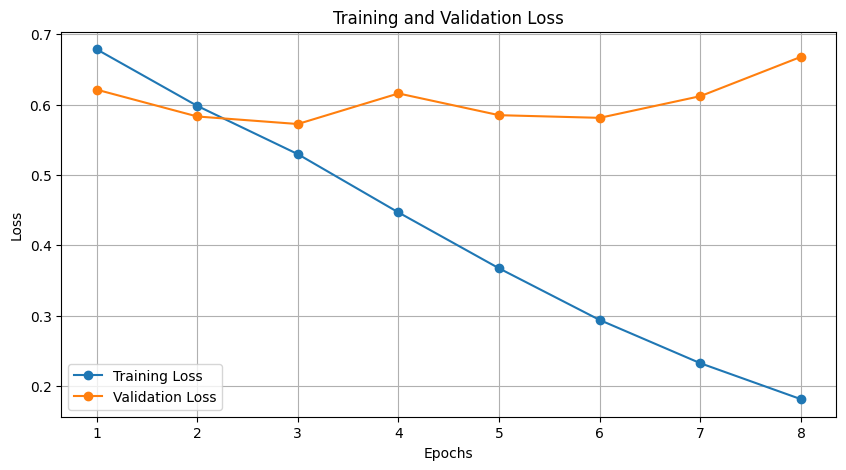

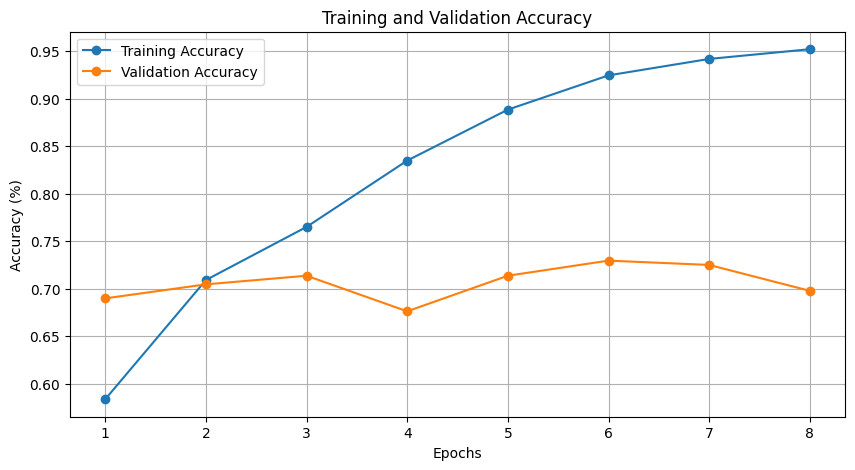

In [27]:
# Example correction: Ensure all arrays have the same length
num_epochs = range(1, len(epoch_train_loss) + 1)  # Adjust to match the length of training/validation data

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(num_epochs, epoch_train_loss, label="Training Loss", marker='o')
plt.plot(num_epochs, epoch_val_loss, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(num_epochs, epoch_train_accuracy, label="Training Accuracy", marker='o')
plt.plot(num_epochs, epoch_val_accuracy, label="Validation Accuracy", marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()


# Testing

In [28]:
#try:
model = HierarchicalBERT()
# Load the saved model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/FALL2024/comp550/final_project/models/best_model_2024-12-16_03-02-41.pth"
))

# Move the model to the appropriate device (e.g., GPU if available)
model.to(device)
# except:
#     disconnect_runtime()

HierarchicalBERT(
  (sentence_encoder): SentenceEncodingLayer(
    (context_encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=76

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def test_model(model, test_loader, device):
    """
    Test the model on the test dataset and return the loss and accuracy.
    """
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():  # Disable gradient calculations for testing
        for batch in tqdm(test_loader, desc="Testing Progress"):
            # Move data to the device
            context = batch['context']
            response = batch['response']
            syntactic_features = batch['syntactic_features'].to(device)
            labels = batch['label'].unsqueeze(1).to(device).float()

            # Forward pass
            logits = model(context, response, syntactic_features)
            loss = criterion(logits, labels)

            # Compute predictions
            predictions = (torch.sigmoid(logits) > 0.5).long()

            # Update metrics
            epoch_loss += loss.item()
            total_predictions += labels.size(0)
            correct_predictions += (predictions == labels.long()).sum().item()

            # Collect true and predicted labels
            all_true_labels.extend(labels.cpu().numpy().flatten())
            all_predicted_labels.extend(predictions.cpu().numpy().flatten())

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)

    # Display the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return avg_loss, accuracy

Recevied a csv file


Testing Progress:   0%|          | 1/225 [00:01<04:39,  1.25s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   1%|          | 2/225 [00:02<04:25,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   1%|▏         | 3/225 [00:03<04:21,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   2%|▏         | 4/225 [00:04<04:18,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   2%|▏         | 5/225 [00:05<04:17,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   3%|▎         | 6/225 [00:07<04:16,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   3%|▎         | 7/225 [00:08<04:14,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   4%|▎         | 8/225 [00:09<04:13,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   4%|▍         | 9/225 [00:10<04:11,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   4%|▍         | 10/225 [00:11<04:11,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   5%|▍         | 11/225 [00:12<04:10,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   5%|▌         | 12/225 [00:14<04:10,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   6%|▌         | 13/225 [00:15<04:09,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   6%|▌         | 14/225 [00:16<04:08,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   7%|▋         | 15/225 [00:17<04:08,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   7%|▋         | 16/225 [00:18<04:07,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   8%|▊         | 17/225 [00:20<04:06,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   8%|▊         | 18/225 [00:21<04:05,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   8%|▊         | 19/225 [00:22<04:05,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   9%|▉         | 20/225 [00:23<04:03,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:   9%|▉         | 21/225 [00:24<04:02,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  10%|▉         | 22/225 [00:26<04:04,  1.21s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  10%|█         | 23/225 [00:27<04:05,  1.21s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  11%|█         | 24/225 [00:28<04:02,  1.21s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  11%|█         | 25/225 [00:29<04:00,  1.20s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  12%|█▏        | 26/225 [00:30<03:57,  1.20s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  12%|█▏        | 27/225 [00:32<03:55,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  12%|█▏        | 28/225 [00:33<03:54,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  13%|█▎        | 29/225 [00:34<03:52,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  13%|█▎        | 30/225 [00:35<03:51,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  14%|█▍        | 31/225 [00:36<03:49,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  14%|█▍        | 32/225 [00:37<03:47,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  15%|█▍        | 33/225 [00:39<03:46,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  15%|█▌        | 34/225 [00:40<03:44,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  16%|█▌        | 35/225 [00:41<03:44,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  16%|█▌        | 36/225 [00:42<03:43,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  16%|█▋        | 37/225 [00:43<03:42,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  17%|█▋        | 38/225 [00:44<03:40,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  17%|█▋        | 39/225 [00:46<03:38,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  18%|█▊        | 40/225 [00:47<03:37,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  18%|█▊        | 41/225 [00:48<03:35,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  19%|█▊        | 42/225 [00:49<03:33,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  19%|█▉        | 43/225 [00:50<03:31,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  20%|█▉        | 44/225 [00:51<03:29,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  20%|██        | 45/225 [00:53<03:28,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  20%|██        | 46/225 [00:54<03:28,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  21%|██        | 47/225 [00:55<03:27,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  21%|██▏       | 48/225 [00:56<03:25,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  22%|██▏       | 49/225 [00:57<03:23,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  22%|██▏       | 50/225 [00:58<03:22,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  23%|██▎       | 51/225 [01:00<03:21,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  23%|██▎       | 52/225 [01:01<03:19,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  24%|██▎       | 53/225 [01:02<03:18,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  24%|██▍       | 54/225 [01:03<03:16,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  24%|██▍       | 55/225 [01:04<03:15,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  25%|██▍       | 56/225 [01:05<03:15,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  25%|██▌       | 57/225 [01:06<03:14,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  26%|██▌       | 58/225 [01:08<03:12,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  26%|██▌       | 59/225 [01:09<03:11,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  27%|██▋       | 60/225 [01:10<03:10,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  27%|██▋       | 61/225 [01:11<03:08,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  28%|██▊       | 62/225 [01:12<03:07,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  28%|██▊       | 63/225 [01:13<03:07,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  28%|██▊       | 64/225 [01:15<03:05,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  29%|██▉       | 65/225 [01:16<03:04,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  29%|██▉       | 66/225 [01:17<03:03,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  30%|██▉       | 67/225 [01:18<03:03,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  30%|███       | 68/225 [01:19<03:02,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  31%|███       | 69/225 [01:20<03:00,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  31%|███       | 70/225 [01:21<02:59,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  32%|███▏      | 71/225 [01:23<02:57,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  32%|███▏      | 72/225 [01:24<02:56,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  32%|███▏      | 73/225 [01:25<02:55,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  33%|███▎      | 74/225 [01:26<02:54,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  33%|███▎      | 75/225 [01:27<02:53,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  34%|███▍      | 76/225 [01:28<02:52,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  34%|███▍      | 77/225 [01:30<02:52,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  35%|███▍      | 78/225 [01:31<02:51,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  35%|███▌      | 79/225 [01:32<02:50,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  36%|███▌      | 80/225 [01:33<02:49,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  36%|███▌      | 81/225 [01:34<02:48,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  36%|███▋      | 82/225 [01:35<02:47,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  37%|███▋      | 83/225 [01:37<02:45,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  37%|███▋      | 84/225 [01:38<02:47,  1.19s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  38%|███▊      | 85/225 [01:39<02:45,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  38%|███▊      | 86/225 [01:40<02:44,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  39%|███▊      | 87/225 [01:41<02:42,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  39%|███▉      | 88/225 [01:43<02:41,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  40%|███▉      | 89/225 [01:44<02:40,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  40%|████      | 90/225 [01:45<02:38,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  40%|████      | 91/225 [01:46<02:36,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  41%|████      | 92/225 [01:47<02:35,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  41%|████▏     | 93/225 [01:48<02:34,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  42%|████▏     | 94/225 [01:50<02:32,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  42%|████▏     | 95/225 [01:51<02:31,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  43%|████▎     | 96/225 [01:52<02:30,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  43%|████▎     | 97/225 [01:53<02:29,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  44%|████▎     | 98/225 [01:54<02:29,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  44%|████▍     | 99/225 [01:55<02:28,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  44%|████▍     | 100/225 [01:57<02:26,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  45%|████▍     | 101/225 [01:58<02:24,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  45%|████▌     | 102/225 [01:59<02:23,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  46%|████▌     | 103/225 [02:00<02:22,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  46%|████▌     | 104/225 [02:01<02:21,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  47%|████▋     | 105/225 [02:02<02:19,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  47%|████▋     | 106/225 [02:04<02:18,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  48%|████▊     | 107/225 [02:05<02:17,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  48%|████▊     | 108/225 [02:06<02:16,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  48%|████▊     | 109/225 [02:07<02:15,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  49%|████▉     | 110/225 [02:08<02:14,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  49%|████▉     | 111/225 [02:09<02:12,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  50%|████▉     | 112/225 [02:11<02:11,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  50%|█████     | 113/225 [02:12<02:10,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  51%|█████     | 114/225 [02:13<02:09,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  51%|█████     | 115/225 [02:14<02:07,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  52%|█████▏    | 116/225 [02:15<02:06,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  52%|█████▏    | 117/225 [02:16<02:05,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  52%|█████▏    | 118/225 [02:18<02:04,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  53%|█████▎    | 119/225 [02:19<02:03,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  53%|█████▎    | 120/225 [02:20<02:02,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  54%|█████▍    | 121/225 [02:21<02:01,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  54%|█████▍    | 122/225 [02:22<01:59,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  55%|█████▍    | 123/225 [02:23<01:58,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  55%|█████▌    | 124/225 [02:25<01:57,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  56%|█████▌    | 125/225 [02:26<01:55,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  56%|█████▌    | 126/225 [02:27<01:54,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  56%|█████▋    | 127/225 [02:28<01:53,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  57%|█████▋    | 128/225 [02:29<01:52,  1.15s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  57%|█████▋    | 129/225 [02:30<01:51,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  58%|█████▊    | 130/225 [02:31<01:50,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  58%|█████▊    | 131/225 [02:33<01:49,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  59%|█████▊    | 132/225 [02:34<01:47,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  59%|█████▉    | 133/225 [02:35<01:46,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  60%|█████▉    | 134/225 [02:36<01:45,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  60%|██████    | 135/225 [02:37<01:44,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  60%|██████    | 136/225 [02:38<01:43,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  61%|██████    | 137/225 [02:40<01:42,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  61%|██████▏   | 138/225 [02:41<01:40,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  62%|██████▏   | 139/225 [02:42<01:39,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  62%|██████▏   | 140/225 [02:43<01:38,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  63%|██████▎   | 141/225 [02:44<01:37,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  63%|██████▎   | 142/225 [02:45<01:36,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  64%|██████▎   | 143/225 [02:47<01:35,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  64%|██████▍   | 144/225 [02:48<01:33,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  64%|██████▍   | 145/225 [02:49<01:32,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  65%|██████▍   | 146/225 [02:50<01:31,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  65%|██████▌   | 147/225 [02:51<01:30,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  66%|██████▌   | 148/225 [02:52<01:29,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  66%|██████▌   | 149/225 [02:54<01:28,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  67%|██████▋   | 150/225 [02:55<01:26,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  67%|██████▋   | 151/225 [02:56<01:26,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  68%|██████▊   | 152/225 [02:57<01:25,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  68%|██████▊   | 153/225 [02:58<01:23,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  68%|██████▊   | 154/225 [02:59<01:22,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  69%|██████▉   | 155/225 [03:01<01:21,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  69%|██████▉   | 156/225 [03:02<01:20,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  70%|██████▉   | 157/225 [03:03<01:19,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  70%|███████   | 158/225 [03:04<01:18,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  71%|███████   | 159/225 [03:05<01:17,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  71%|███████   | 160/225 [03:06<01:15,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  72%|███████▏  | 161/225 [03:08<01:14,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  72%|███████▏  | 162/225 [03:09<01:13,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  72%|███████▏  | 163/225 [03:10<01:12,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  73%|███████▎  | 164/225 [03:11<01:11,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  73%|███████▎  | 165/225 [03:12<01:09,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  74%|███████▍  | 166/225 [03:13<01:08,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  74%|███████▍  | 167/225 [03:15<01:07,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  75%|███████▍  | 168/225 [03:16<01:06,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  75%|███████▌  | 169/225 [03:17<01:05,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  76%|███████▌  | 170/225 [03:18<01:03,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  76%|███████▌  | 171/225 [03:19<01:02,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  76%|███████▋  | 172/225 [03:20<01:01,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  77%|███████▋  | 173/225 [03:22<01:01,  1.18s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  77%|███████▋  | 174/225 [03:23<00:59,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  78%|███████▊  | 175/225 [03:24<00:58,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  78%|███████▊  | 176/225 [03:25<00:57,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  79%|███████▊  | 177/225 [03:26<00:55,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  79%|███████▉  | 178/225 [03:27<00:54,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  80%|███████▉  | 179/225 [03:29<00:53,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  80%|████████  | 180/225 [03:30<00:52,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  80%|████████  | 181/225 [03:31<00:51,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  81%|████████  | 182/225 [03:32<00:50,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  81%|████████▏ | 183/225 [03:33<00:49,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  82%|████████▏ | 184/225 [03:34<00:48,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  82%|████████▏ | 185/225 [03:36<00:46,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  83%|████████▎ | 186/225 [03:37<00:45,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  83%|████████▎ | 187/225 [03:38<00:44,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  84%|████████▎ | 188/225 [03:39<00:43,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  84%|████████▍ | 189/225 [03:40<00:41,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  84%|████████▍ | 190/225 [03:41<00:40,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  85%|████████▍ | 191/225 [03:43<00:39,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  85%|████████▌ | 192/225 [03:44<00:38,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  86%|████████▌ | 193/225 [03:45<00:37,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  86%|████████▌ | 194/225 [03:46<00:36,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  87%|████████▋ | 195/225 [03:47<00:35,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  87%|████████▋ | 196/225 [03:48<00:33,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  88%|████████▊ | 197/225 [03:50<00:32,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  88%|████████▊ | 198/225 [03:51<00:31,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  88%|████████▊ | 199/225 [03:52<00:30,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  89%|████████▉ | 200/225 [03:53<00:29,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  89%|████████▉ | 201/225 [03:54<00:27,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  90%|████████▉ | 202/225 [03:55<00:26,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  90%|█████████ | 203/225 [03:57<00:25,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  91%|█████████ | 204/225 [03:58<00:24,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  91%|█████████ | 205/225 [03:59<00:23,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  92%|█████████▏| 206/225 [04:00<00:22,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  92%|█████████▏| 207/225 [04:01<00:20,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  92%|█████████▏| 208/225 [04:02<00:19,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  93%|█████████▎| 209/225 [04:03<00:18,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  93%|█████████▎| 210/225 [04:05<00:17,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  94%|█████████▍| 211/225 [04:06<00:16,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  94%|█████████▍| 212/225 [04:07<00:15,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  95%|█████████▍| 213/225 [04:08<00:13,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  95%|█████████▌| 214/225 [04:09<00:12,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  96%|█████████▌| 215/225 [04:10<00:11,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  96%|█████████▌| 216/225 [04:12<00:10,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  96%|█████████▋| 217/225 [04:13<00:09,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  97%|█████████▋| 218/225 [04:14<00:08,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  97%|█████████▋| 219/225 [04:15<00:06,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  98%|█████████▊| 220/225 [04:16<00:05,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  98%|█████████▊| 221/225 [04:17<00:04,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  99%|█████████▊| 222/225 [04:19<00:03,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress:  99%|█████████▉| 223/225 [04:20<00:02,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress: 100%|█████████▉| 224/225 [04:21<00:01,  1.16s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])


Testing Progress: 100%|██████████| 225/225 [04:22<00:00,  1.17s/it]

CNN Context Output Shape: torch.Size([8, 384])
CNN Response Output Shape: torch.Size([8, 384])
Syntactic Feature Embedding Shape: torch.Size([8, 600])
Flattened CNN Context Shape: torch.Size([8, 384])
Flattened CNN Response Shape: torch.Size([8, 384])
Confusion Matrix:
[[454 446]
 [202 698]]


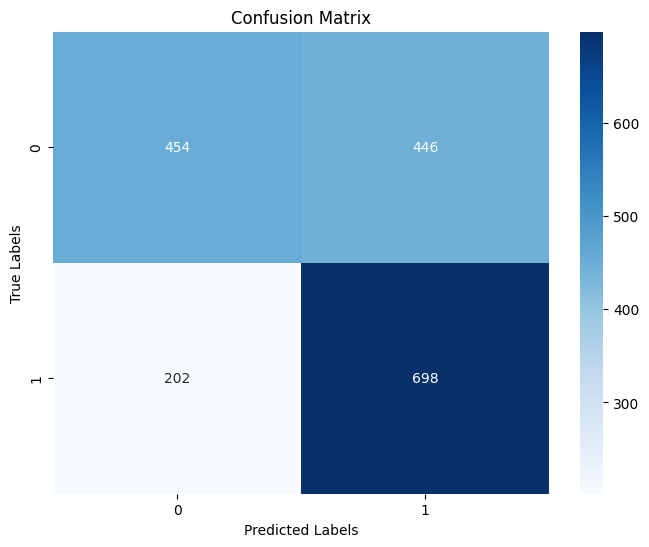

[Test] Loss: 0.6807, Accuracy: 64.00%


In [34]:
# Test the model
from tqdm import tqdm
reddit_test_set  = RedditDataset(REDDIT_TESTING_PATH_DATAFRAME, SYNTACTIC_TESTING_OUTPUT, device)
reddit_test_data_loader = DataLoader(reddit_test_set, batch_size=8, shuffle=False, collate_fn=custom_collate_fn, generator=torch.Generator(device=device))
test_loss, test_accuracy = test_model(model, test_loader=reddit_test_data_loader, device=device)

print(f"[Test] Loss: {test_loss:.4f}, Accuracy: {test_accuracy * 100:.2f}%")